# Final Team Project - Group 3

## Machine learning: Fundamentals and Applications (AAI-510-IN1)

**University of San Diego**

**Shruthi AK**

**Prof. Dr. Premkumar Chithaluru**

**23.06.2025**



# The Sound of Feelings: Analyzing Emotional Speech Patterns



**Overview**

"The Sound of Feelings" is a machine learning project that explores the emotional signatures embedded in human speech. Using the RAVDESS Emotional Speech Audio dataset, the objective is to train models that can identify and understand emotions based on acoustic features like pitch, energy, zero-crossing rate, MFCCs, and more.

By teaching machines to listen the way humans do, this project attempts to bridge the gap between technology and human emotions through the art of vocal expression.

**Problem Statement and Justification**

Human communication relies heavily on tone and emotion. Identifying emotional content in speech is essential for human-computer interaction, therapy, customer service, and accessibility technology. The main goal of this project is to classify emotional states from raw speech signals and understand why certain acoustic features correlate with specific emotions.

We approached this problem using classical machine learning models, neural networks, and feature-rich spectrogram analysis to explore and predict emotional categories.

**Dataset Description**

Source: Kaggle RAVDESS Dataset

Size: 1440 audio-only files (.wav format)

Actors: 24 (12 male, 12 female)

Emotions: Calm, Happy, Sad, Angry, Fearful, Surprise, Disgust, Neutral

Sampling Rate: 48kHz

Each file name contains encoded metadata like emotion, intensity, repetition, and actor identity. We used these identifiers for label extraction and emotional categorization.



# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzip Audio Dataset

In [9]:
!unzip '/content/drive/MyDrive/Audio.zip' -d '/content/audio_dataset'

Archive:  /content/drive/MyDrive/Audio.zip
  inflating: /content/audio_dataset/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-02-02-02-02-01.wav  
  inflating: /content/audio_dataset/Actor_01/03-01-03-01-01-01-01.wav  
  inflating: /content

# Import libraries

In [1]:
!pip install pyloudnorm

In [2]:
!pip install xgboost

In [35]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [46]:
import os
import gc
import math
import itertools
import json
import time
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import pyloudnorm as pyln
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from joblib import delayed, Parallel

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB



from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

# EDA and Preprocessing

Graphical and statistical methods were used:

Count plots: Emotion distribution

Strip/Swarm/Point/Bar plots: Duration, pitch, energy, and zero-crossing rate by emotion

Spectrograms: Visualizing frequency distribution over time

Correlation heatmaps: Relationship between acoustic features

In [47]:
# Base directory where files are extracted
base_dir = "/content/audio_dataset"

In [48]:
# Lists to hold parsed data
emotion_labels = []
audio_file_paths = []

# Helper function to extract .wav file paths and associated emotion codes
def extract_audio_data_from_dir(directory_path):
    for root_dir, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith('.wav'):
                parts = filename.split('.')[0].split('-')
                if len(parts) >= 3:
                    try:
                        emotion_code = int(parts[2])
                        emotion_labels.append(emotion_code)
                        audio_file_paths.append(os.path.join(root_dir, filename))
                    except ValueError:
                        continue  # Skip files with unexpected naming format

In [49]:
# Traverse dataset directories
extract_audio_data_from_dir(os.path.join(base_dir, "audio_speech_actors_01-24"))
extract_audio_data_from_dir(base_dir)

# Combine into DataFrame
emotion_df = pd.DataFrame(emotion_labels, columns=['EmotionCode'])
path_df = pd.DataFrame(audio_file_paths, columns=['AudioPath'])
audio_emotion_df = pd.concat([emotion_df, path_df], axis=1)

# Map numeric emotion codes to labels
emotion_code_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
audio_emotion_df['EmotionLabel'] = audio_emotion_df['EmotionCode'].map(emotion_code_map)

In [50]:
# Save as CSV
output_dir = "/content/EmotionData"
os.makedirs(output_dir, exist_ok=True)
audio_emotion_df.to_csv(os.path.join(output_dir, "emotion_audio_dataset.csv"), index=False)

In [51]:
# View the CSV
audio_emotion_df.head(10)

EmotionCode                                          AudioPath EmotionLabel
0            8  /content/audio_dataset/audio_speech_actors_01-...     surprise
1            2  /content/audio_dataset/audio_speech_actors_01-...         calm
2            8  /content/audio_dataset/audio_speech_actors_01-...     surprise
3            2  /content/audio_dataset/audio_speech_actors_01-...         calm
4            1  /content/audio_dataset/audio_speech_actors_01-...      neutral
5            6  /content/audio_dataset/audio_speech_actors_01-...         fear
6            4  /content/audio_dataset/audio_speech_actors_01-...          sad
7            4  /content/audio_dataset/audio_speech_actors_01-...          sad
8            1  /content/audio_dataset/audio_speech_actors_01-...      neutral
9            7  /content/audio_dataset/audio_speech_actors_01-...      disgust

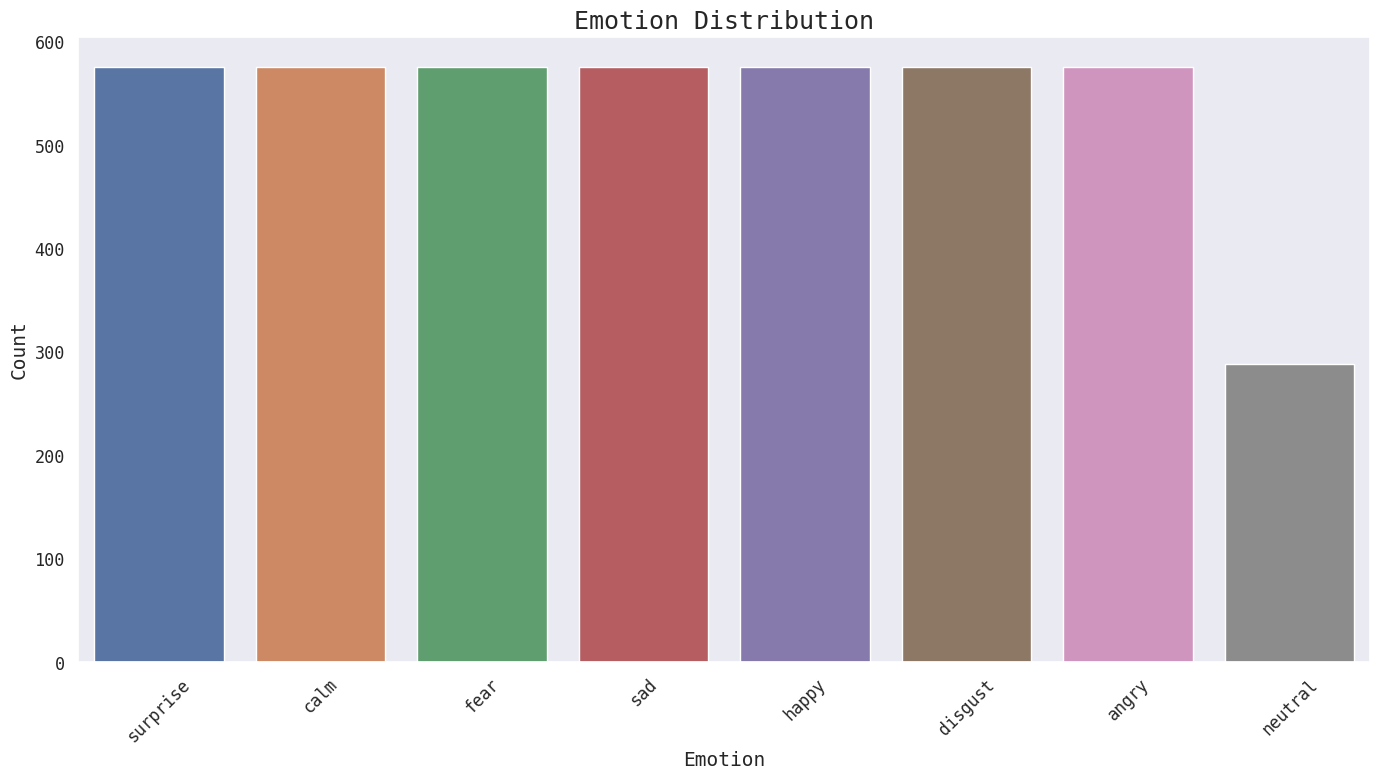

In [9]:
# Dark aesthetic theme
sns.set_theme(
    context='notebook',
    style='dark',
    palette='rocket',
    font='monospace',
    font_scale=1.1,
    color_codes=True
)

plt.figure(figsize=(14, 8))
sns.countplot(
    x='EmotionLabel',
    data=audio_emotion_df,
    order=audio_emotion_df['EmotionLabel'].value_counts().index,
    palette='deep'  # clean, modern colors
)
plt.title('Emotion Distribution', fontsize=18)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()


# Save and display plot
plt.savefig(os.path.join(output_dir, "emotions_plot.png"))
plt.show()

## Spectogram

In [22]:
def generate_and_save_spectrogram(audio_path, emotion_name, output_root):
    """
    Generates a spectrogram from the given audio file and saves it as a PNG image
    in a subdirectory named after the emotion label.
    """
    try:
        # Load the audio file
        signal, sample_rate = librosa.load(audio_path)

        # Compute the Short-Time Fourier Transform (STFT)
        stft_result = librosa.stft(signal)
        stft_db = librosa.amplitude_to_db(abs(stft_result))

        # Define emotion-specific output directory
        emotion_folder = os.path.join(output_root, emotion_name)
        os.makedirs(emotion_folder, exist_ok=True)

        # Create filename by replacing .wav with .png
        file_name = os.path.basename(audio_path).replace('.wav', '.png')
        output_path = os.path.join(emotion_folder, file_name)

        # Plot the spectrogram
        plt.figure(figsize=(10, 3))
        librosa.display.specshow(stft_db, sr=sample_rate, x_axis='time', y_axis='hz')
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"{emotion_name}", fontsize=12)
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()

    except Exception as error:
        print(f"Error generating spectrogram for {audio_path}: {error}")

In [ ]:
# Directory where spectrograms will be saved
spectrogram_output_dir = os.path.join(output_dir, "spectrograms")

# Generate and save spectrograms for all audio files
for _, row in tqdm(audio_emotion_df.iterrows(), total=len(audio_emotion_df), desc="Generating Spectrograms"):
    generate_and_save_spectrogram(row['AudioPath'], row['EmotionLabel'], spectrogram_output_dir)

Generating Spectrograms:  24%|██▍       | 1031/4320 [08:06<27:38,  1.98it/s]

# Feature Engineering and Data Preparation

Parsing: Extracted file paths and emotion labels from filenames

Audio Processing:

Computed pitch, energy, zero-crossing rate, and duration

Extracted 15 MFCCs per audio sample

Normalization: Used RobustScaler instead of StandardScaler to reduce the impact of outliers

Label Encoding: Transformed categorical emotion labels to numeric

In [52]:
# Take a random sample of 1500 audio files from the full dataset
sampled_audio_df = audio_emotion_df.sample(n=2000, random_state=42).copy()

# Initialize lists to store extracted audio features
durations = []
pitches = []
energies = []
zcr_values = []

# Extract audio features from each sampled file
for audio_file in sampled_audio_df['AudioPath']:
    y, sr = librosa.load(audio_file, sr=None)

    # Pitch
    pitch_matrix, magnitude_matrix = librosa.piptrack(y=y, sr=sr)
    mean_pitch = pitch_matrix[magnitude_matrix > np.median(magnitude_matrix)].mean()

    # Energy
    mean_energy = np.mean(y**2)

    # Duration
    duration_sec = librosa.get_duration(y=y, sr=sr)

    # Zero Crossing Rate
    mean_zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

    pitches.append(mean_pitch)
    energies.append(mean_energy)
    durations.append(duration_sec)
    zcr_values.append(mean_zcr)

# Add extracted features to the sampled DataFrame
sampled_audio_df['Duration'] = durations
sampled_audio_df['Pitch'] = pitches
sampled_audio_df['Energy'] = energies
sampled_audio_df['ZCR'] = zcr_values

In [53]:
# custom colors for each emotion
emotion_color_palette = {
    "happy": "#F4D03F",      # golden yellow
    "sad": "#3498DB",        # rich blue
    "angry": "#C0392B",      # dark red
    "neutral": "#7F8C8D",    # stone gray
    "calm": "#48C9B0",       # mint green
    "fear": "#9B59B6",       # soft violet
    "disgust": "#27AE60",    # emerald green
    "surprise": "#F1948A"
}

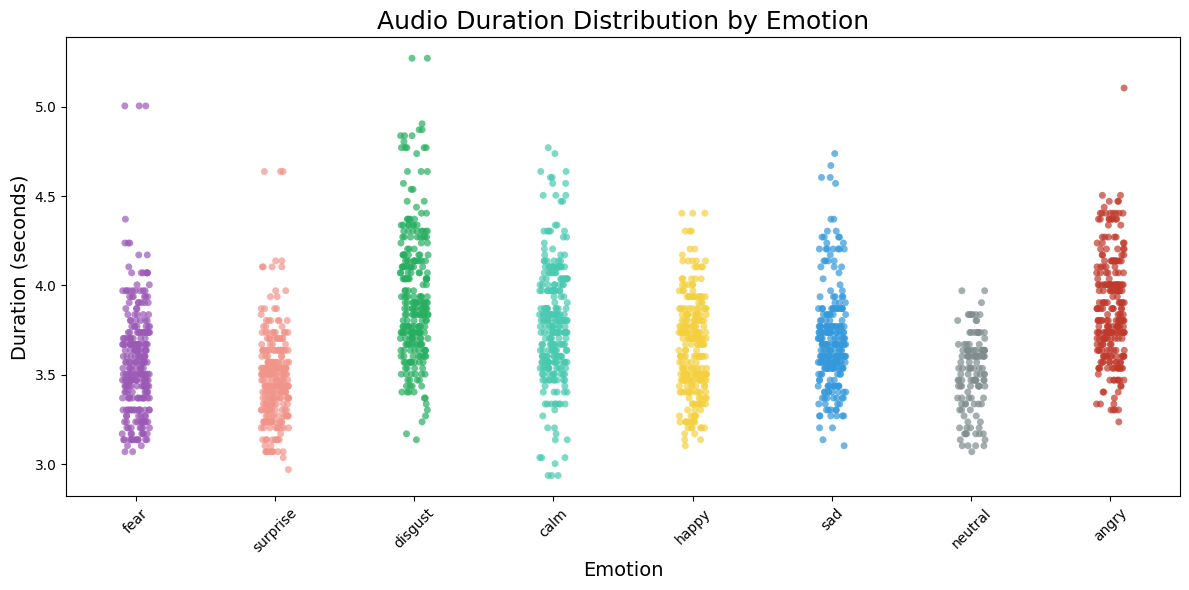

In [54]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='EmotionLabel', y='Duration', data=sampled_audio_df,
              palette=emotion_color_palette, jitter=True, size=5, alpha=0.7)
plt.title("Audio Duration Distribution by Emotion", fontsize=18)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Duration (seconds)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

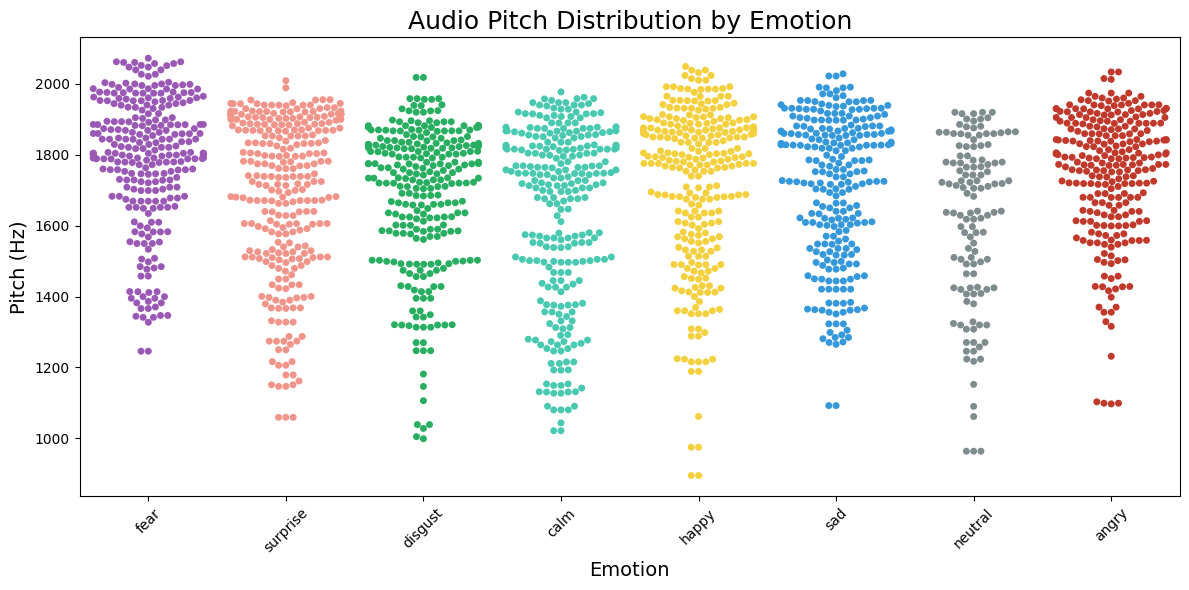

In [55]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='EmotionLabel', y='Pitch', data=sampled_audio_df,
              palette=emotion_color_palette, size=5)
plt.title("Audio Pitch Distribution by Emotion", fontsize=18)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Pitch (Hz)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

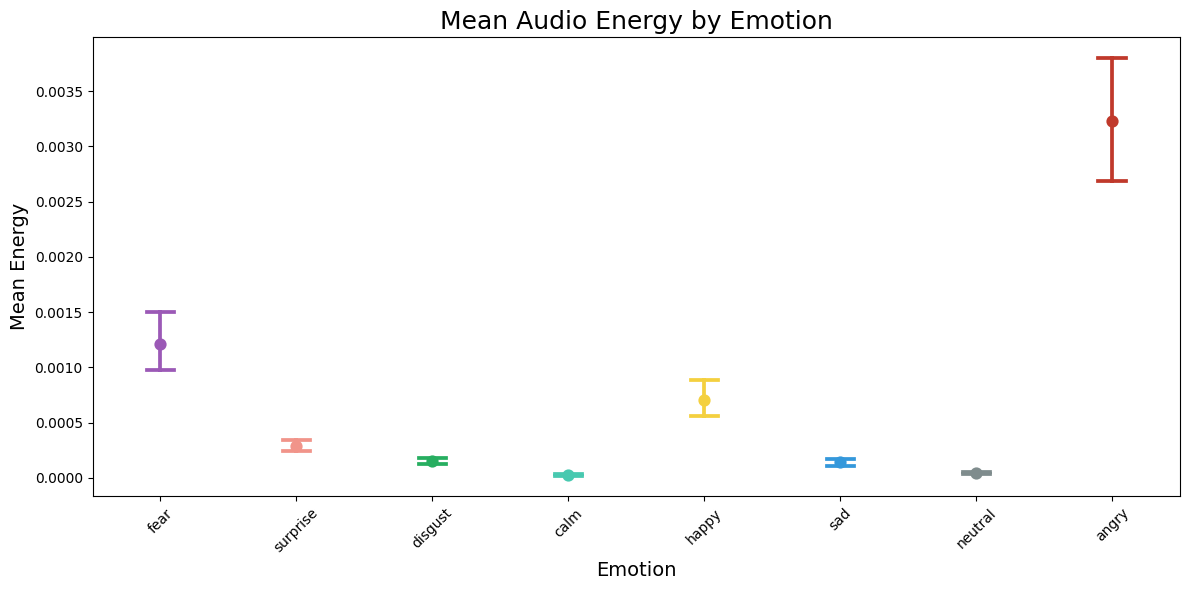

In [56]:
plt.figure(figsize=(12, 6))
sns.pointplot(x='EmotionLabel', y='Energy', data=sampled_audio_df,
              palette=emotion_color_palette, join=False, capsize=0.2)
plt.title("Mean Audio Energy by Emotion", fontsize=18)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Mean Energy", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

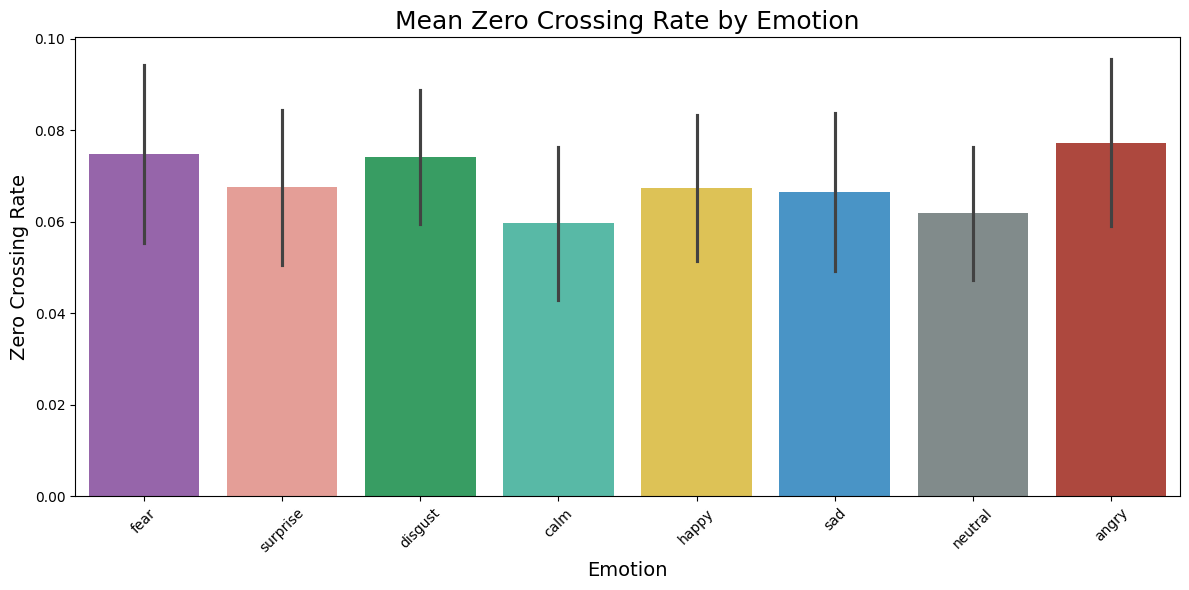

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x='EmotionLabel', y='ZCR', data=sampled_audio_df,
            palette=emotion_color_palette, ci="sd")
plt.title("Mean Zero Crossing Rate by Emotion", fontsize=18)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Zero Crossing Rate", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Function to normalize and clean emotion labels
def normalize_emotion_label(label):
    if isinstance(label, (np.ndarray, list)):
        return str(label[0])
    return str(label)

In [8]:
# Clean up any inconsistent emotion labels
sampled_audio_df['EmotionLabel'] = sampled_audio_df['EmotionLabel'].apply(normalize_emotion_label)

## Feature Selection

Features were selected based on:

Variability across emotion classes (e.g., pitch varies most for happy/fearful)

Correlation with the target emotion class

Experiments with different k-values in KMeans and performance of decision trees

Selected features included: Pitch, Energy, ZCR, Duration, and MFCC_1 to MFCC_15.

In [9]:
# Function to extract MFCCs
def extract_mfcc_features(audio_file, n_mfcc=15):
    try:
        y, sr = librosa.load(audio_file, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs, axis=1)
    except Exception as e:
        print(f"Failed MFCC extraction from {audio_file}: {e}")
        return np.zeros(n_mfcc)

In [10]:
# Extract MFCC features for each audio file
mfcc_feature_list = []
for audio_file in sampled_audio_df['AudioPath']:
    mfcc_feature_list.append(extract_mfcc_features(audio_file, n_mfcc=15))

# Convert MFCC features into DataFrame
mfcc_feature_df = pd.DataFrame(mfcc_feature_list, columns=[f'MFCC_{i+1}' for i in range(15)])
mfcc_feature_df.reset_index(drop=True, inplace=True)
sampled_audio_df.reset_index(drop=True, inplace=True)

In [11]:
# Combine MFCCs with other features
feature_df = pd.concat([
    mfcc_feature_df,
    sampled_audio_df[['Pitch', 'Energy', 'ZCR', 'Duration', 'EmotionLabel']]
], axis=1)

In [29]:
feature_df.head()

MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -497.267181  29.747702 -16.749750  -2.781938 -13.290050  -4.604352   
1 -561.738159  63.771156  -8.193513  10.717543   1.528304  11.123491   
2 -645.410645  75.006981  -5.645598  11.208323   5.156332   7.834976   
3 -700.848328  73.979218  13.752046  24.008165   2.642706  15.747820   
4 -800.919861  50.396084   6.960778  13.710006  -5.116372   4.601861   

      MFCC_7    MFCC_8     MFCC_9   MFCC_10   MFCC_11   MFCC_12   MFCC_13  \
0 -16.823717 -5.616928  -8.648810 -9.526477 -6.052828 -4.417263 -5.346954   
1  -9.027408 -1.619140  -2.938692 -9.928777 -9.759050  1.479662 -0.939398   
2  -6.709151  0.784336  -9.749146 -7.461309  2.192308  1.225093 -5.925898   
3  -3.245348  6.640845  -6.408341 -4.687808 -0.684048  2.455816 -2.964346   
4  -7.781662  3.272309 -11.155941 -1.797051 -3.456108 -1.959189 -1.131546   

    MFCC_14   MFCC_15        Pitch    Energy       ZCR  Duration EmotionLabel  
0 -2.165839  3.389515  1975.916504  0.001157  0.094916  4.070729         fear  
1 -8.157356 -5.541070  1886.320190  0.000508  0.070377  3.470146     surprise  
2 -2.580539  0.332043  1735.041016  0.000045  0.060875  3.737062      disgust  
3 -0.750196 -2.388092  1269.823853  0.000024  0.069154  3.937271      disgust  
4 -3.742565 -3.461024  1825.969971  0.000003  0.060490  3.737062         calm

In [30]:
feature_df['EmotionLabel'].value_counts()

EmotionLabel
surprise    282
fear        273
calm        273
disgust     270
happy       269
angry       256
sad         252
neutral     125
Name: count, dtype: int64

In [31]:
feature_df.describe()

MFCC_1       MFCC_2       MFCC_3       MFCC_4       MFCC_5  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean   -618.457886    65.781570    -4.643002    10.301273    -0.265238   
std     100.004158    14.611405    11.708288     8.168470     6.887895   
min    -873.242310    18.962200   -51.957912   -17.508692   -22.566322   
25%    -693.353943    55.540034   -12.256225     4.729426    -5.063827   
50%    -625.892120    66.068928    -3.692443    10.311200    -0.467768   
75%    -553.163635    75.982845     3.577858    15.233767     4.873952   
max    -333.377960   110.981491    22.603916    36.563427    21.130016   

            MFCC_6       MFCC_7       MFCC_8       MFCC_9      MFCC_10  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      8.167881    -8.399657     0.961017    -7.083739    -5.577426   
std       7.151240     6.026907     5.148296     4.875229     4.356740   
min     -11.918347   -29.964558   -16.975168   -21.486059   -21.439531   
25%       2.795366   -12.362157    -2.576894   -10.732538    -8.760663   
50%       8.558703    -8.973296     0.830992    -7.637449    -5.630704   
75%      13.434915    -4.454705     4.362810    -3.310813    -2.199036   
max      25.823013    10.092591    16.410280     6.087853     7.422122   

           MFCC_11      MFCC_12      MFCC_13      MFCC_14      MFCC_15  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     -4.066771    -1.930307    -1.759953    -3.111051    -2.970052   
std       3.731323     3.257063     3.948246     3.439200     3.347444   
min     -17.051992   -15.883946   -13.192415   -13.353581   -13.080017   
25%      -6.417119    -4.051571    -4.960642    -5.332899    -5.221140   
50%      -4.095771    -2.142579    -1.592526    -3.305322    -3.211582   
75%      -1.692411     0.252324     1.265775    -1.033285    -0.887127   
max       9.350845    18.046015    13.240598     9.045076    18.721136   

             Pitch        Energy          ZCR     Duration  
count  2000.000000  2.000000e+03  2000.000000  2000.000000  
mean   1701.023193  7.585760e-04     0.069072     3.702966  
std     220.666077  2.144486e-03     0.017882     0.334563  
min     894.840393  4.249464e-07     0.029217     2.936271  
25%    1568.141815  2.588635e-05     0.057052     3.470146  
50%    1763.358093  9.584845e-05     0.066108     3.670333  
75%    1868.641602  3.804911e-04     0.079790     3.870542  
max    2072.602539  2.315510e-02     0.168519     5.271937

In [32]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MFCC_1        2000 non-null   float32
 1   MFCC_2        2000 non-null   float32
 2   MFCC_3        2000 non-null   float32
 3   MFCC_4        2000 non-null   float32
 4   MFCC_5        2000 non-null   float32
 5   MFCC_6        2000 non-null   float32
 6   MFCC_7        2000 non-null   float32
 7   MFCC_8        2000 non-null   float32
 8   MFCC_9        2000 non-null   float32
 9   MFCC_10       2000 non-null   float32
 10  MFCC_11       2000 non-null   float32
 11  MFCC_12       2000 non-null   float32
 12  MFCC_13       2000 non-null   float32
 13  MFCC_14       2000 non-null   float32
 14  MFCC_15       2000 non-null   float32
 15  Pitch         2000 non-null   float32
 16  Energy        2000 non-null   float32
 17  ZCR           2000 non-null   float64
 18  Duration      2000 non-null 

## Label Encoding

In [12]:
# Encode emotion labels as integers
label_encoder = LabelEncoder()
feature_df['EmotionEncoded'] = label_encoder.fit_transform(feature_df['EmotionLabel'])

# Optional: Display label-to-integer mapping
emotion_label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
emotion_label_map

{'angry': np.int64(0),
 'calm': np.int64(1),
 'disgust': np.int64(2),
 'fear': np.int64(3),
 'happy': np.int64(4),
 'neutral': np.int64(5),
 'sad': np.int64(6),
 'surprise': np.int64(7)}

# Modelling and Evaluation

In [13]:
# Updated dictionary of ML models
ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "HistGradient Boosting": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0),
    "CatBoost": CatBoostClassifier(verbose=0),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network (MLP)": MLPClassifier(max_iter=500),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [14]:
def train_evaluate_and_plot(X_train, X_test, y_train, y_test, label_suffix=""):
    """
    Trains multiple ML models, evaluates them on both training and testing data,
    and visualizes performance using confusion matrices and ROC curves.
    """
    evaluation_results = []
    color_map = cm.get_cmap('tab10')  # For distinct ROC colors

    for idx, (model_name, model) in enumerate(ml_models.items()):
        print(f"\nTraining: {model_name + label_suffix}")
        model.fit(X_train, y_train)

        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Evaluation on training data
        evaluation_results.append({
            "Model": model_name + label_suffix,
            "Set": "Train",
            "Accuracy": accuracy_score(y_train, y_pred_train),
            "Loss": 1 - accuracy_score(y_train, y_pred_train),
            "Precision": precision_score(y_train, y_pred_train, average='weighted', zero_division=0),
            "Recall": recall_score(y_train, y_pred_train, average='weighted'),
            "F1 Score": f1_score(y_train, y_pred_train, average='weighted')
        })

        # Evaluation on test data
        evaluation_results.append({
            "Model": model_name + label_suffix,
            "Set": "Test",
            "Accuracy": accuracy_score(y_test, y_pred_test),
            "Loss": 1 - accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
            "Recall": recall_score(y_test, y_pred_test, average='weighted'),
            "F1 Score": f1_score(y_test, y_pred_test, average='weighted')
        })

        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        cmatrix = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(cmatrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[0], cbar=False, annot_kws={"size": 10})
        axes[0].set_title(f'Confusion Matrix\n{model_name + label_suffix}', fontsize=12)
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")
        axes[0].tick_params(axis='x', rotation=45)

        # ROC Curve
        if y_proba_test is not None:
            y_test_binarized = label_binarize(y_test, classes=np.unique(y))
            if y_proba_test.shape[1] == n_classes:
                for i in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba_test[:, i])
                    roc_auc = auc(fpr, tpr)
                    axes[1].plot(fpr, tpr, label=f'{class_names[i]} (AUC={roc_auc:.2f})',
                                 color=color_map(i % 10))
                axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
                axes[1].set_title(f'ROC Curve\n{model_name + label_suffix}', fontsize=12)
                axes[1].set_xlabel("False Positive Rate")
                axes[1].set_ylabel("True Positive Rate")
                axes[1].legend(fontsize=9)
                axes[1].grid(True)
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, 'No Probability Output\nUnavailable for ROC',
                         ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()

    return pd.DataFrame(evaluation_results)

## Modelling and Evaluation without ***RobustScaler***

### Split Train and Test Data without ***RobustScaler***

In [15]:
X = feature_df.drop(['EmotionLabel', 'EmotionEncoded'], axis=1)
y = feature_df['EmotionEncoded']

class_names = label_encoder.classes_
n_classes = len(class_names)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
X_train.shape

(1600, 19)

In [17]:
X_test.shape

(400, 19)

In [18]:
y_train.shape

(1600,)

In [19]:
y_test.shape

(400,)

### Train models and plot results without ***RobustScaler***


Training: Logistic Regression (Without Scaling)


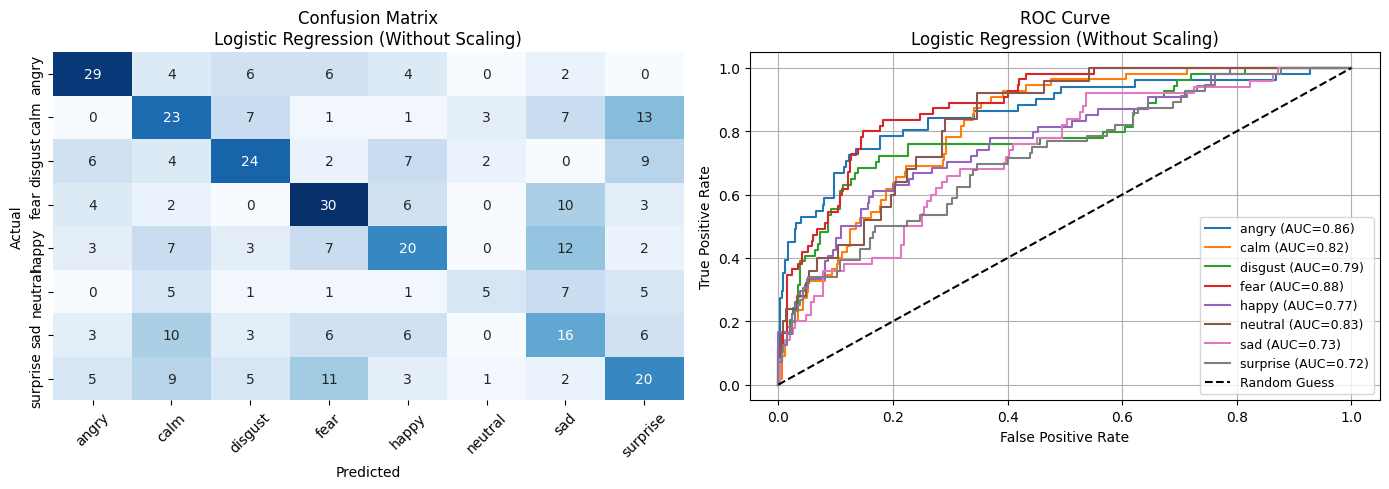


Training: Random Forest (Without Scaling)


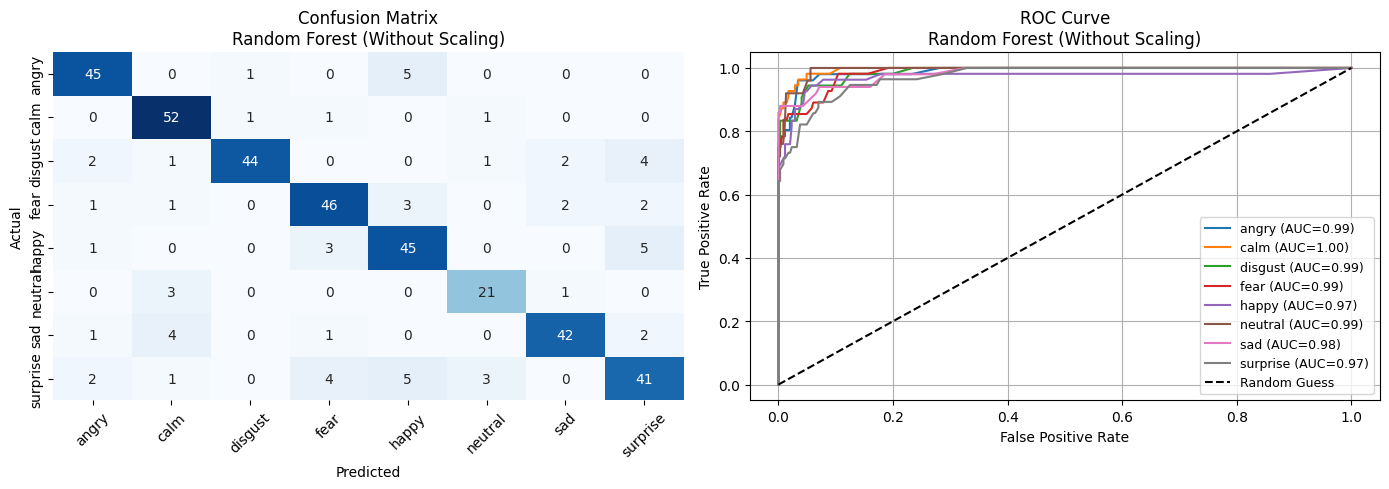


Training: Decision Tree (Without Scaling)


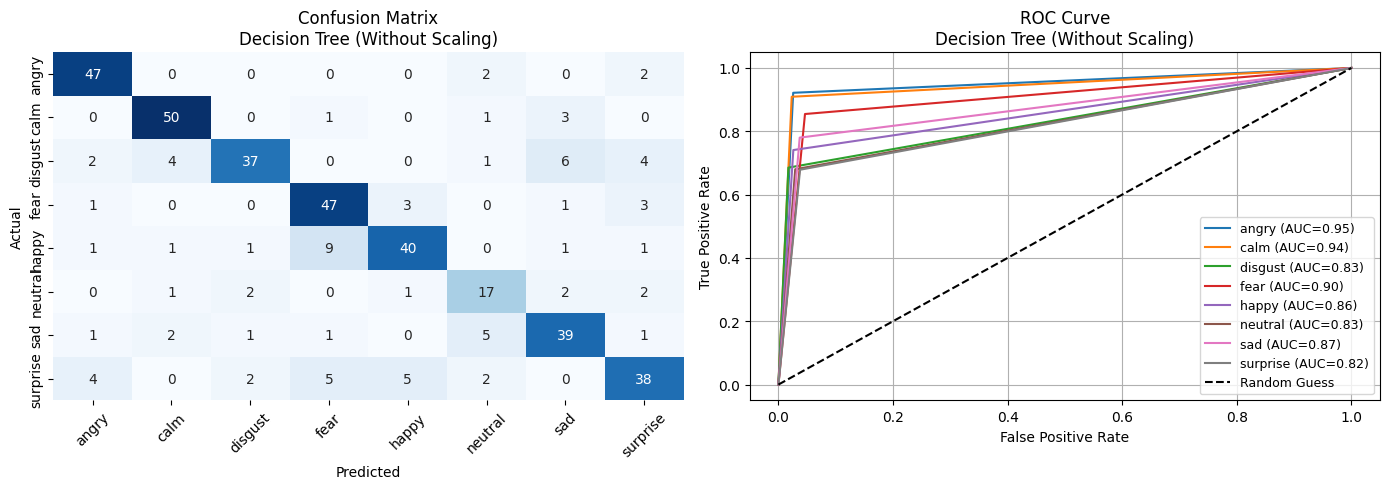


Training: Gradient Boosting (Without Scaling)


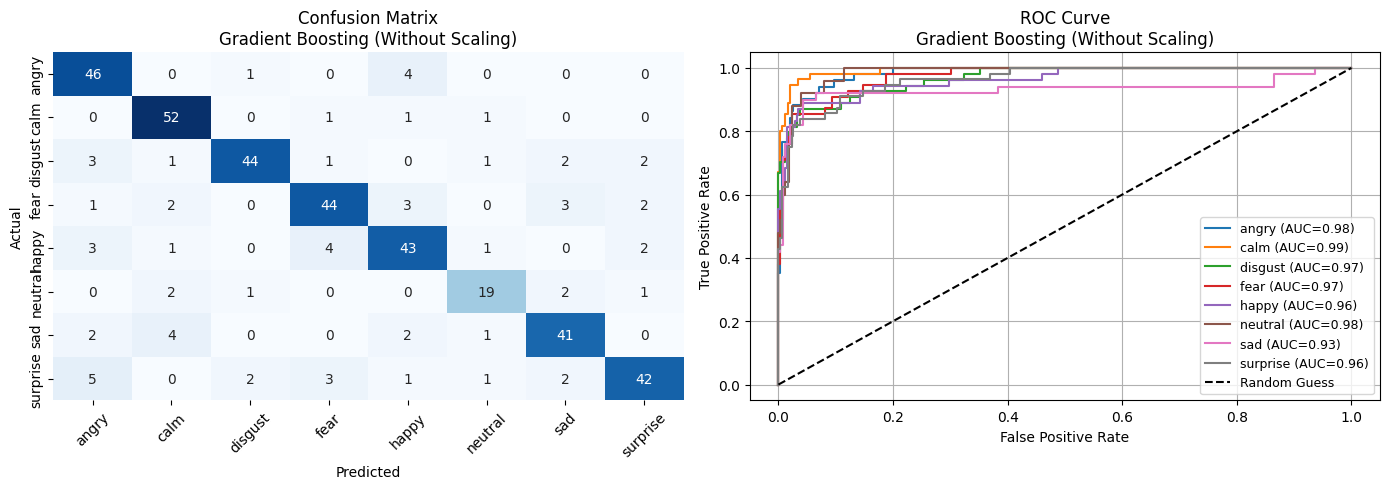


Training: HistGradient Boosting (Without Scaling)


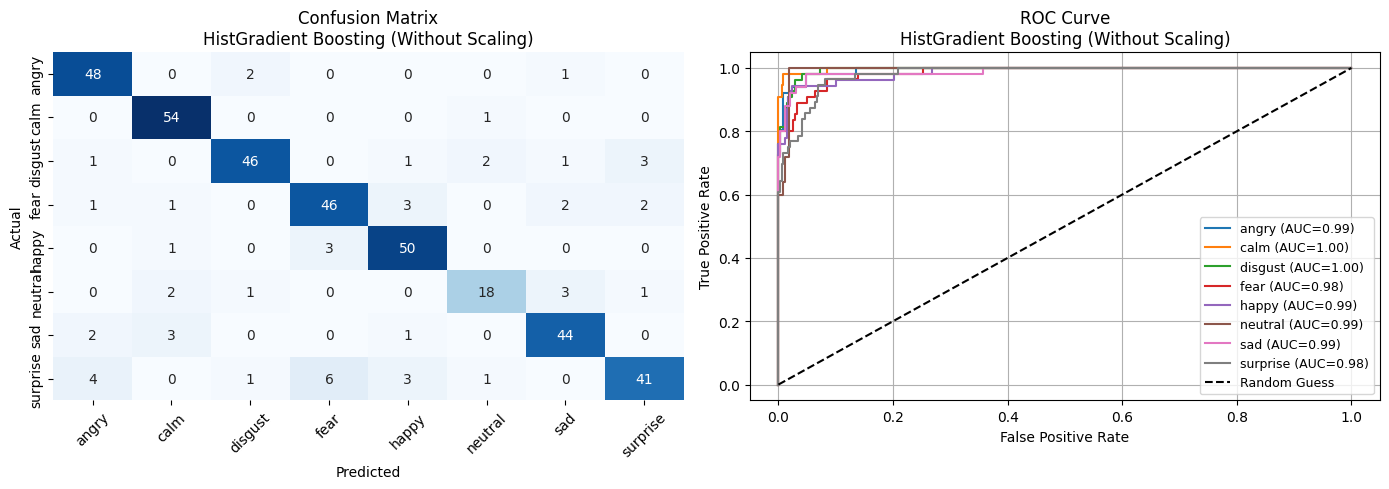


Training: XGBoost (Without Scaling)


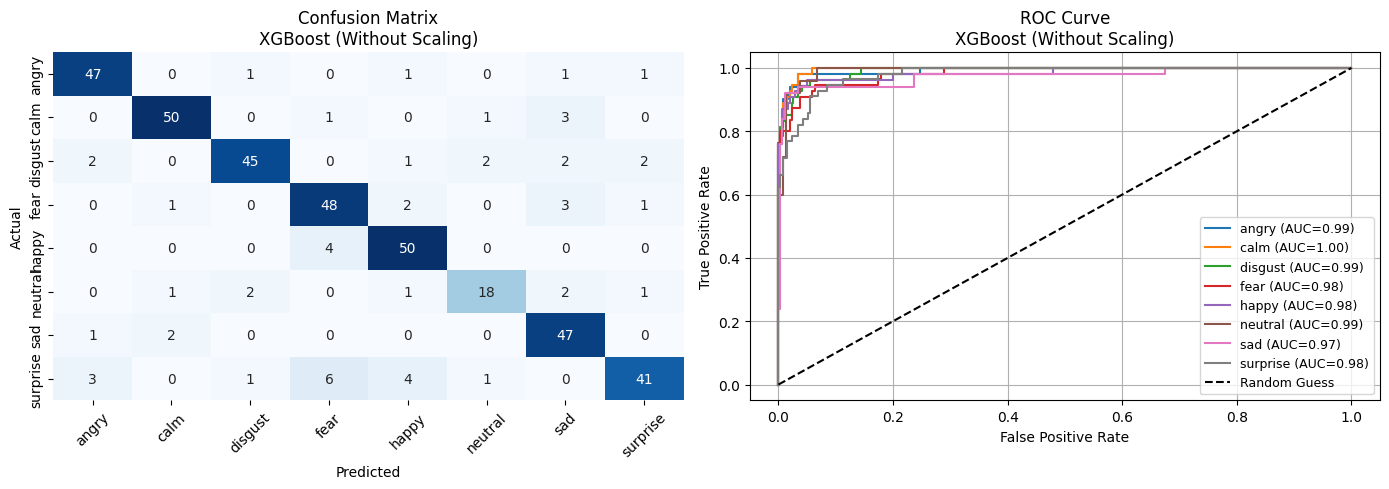


Training: CatBoost (Without Scaling)


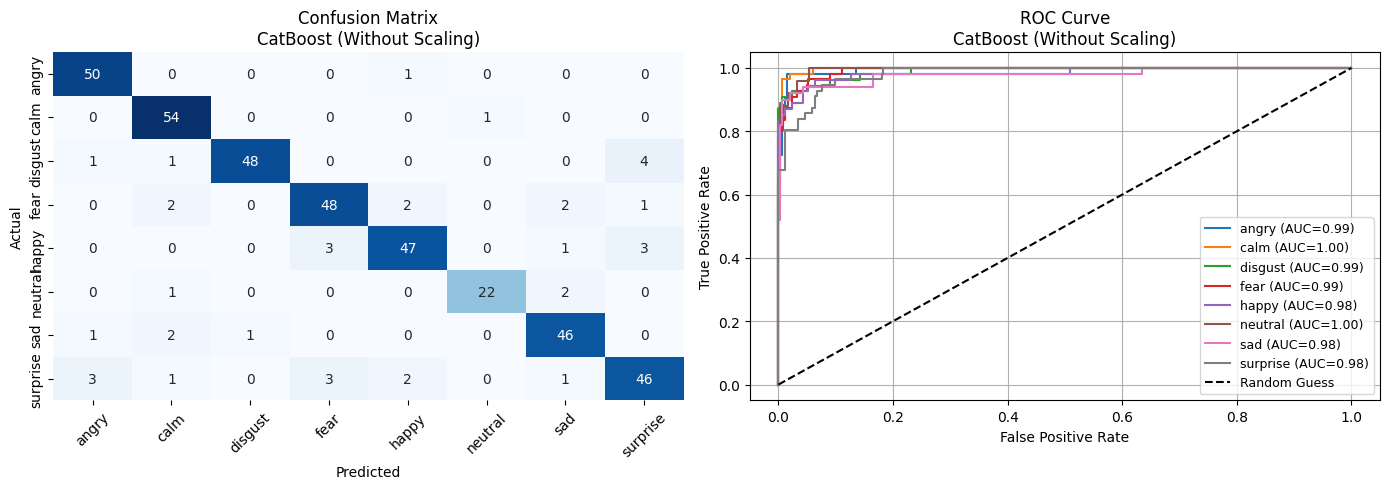


Training: K-Nearest Neighbors (Without Scaling)


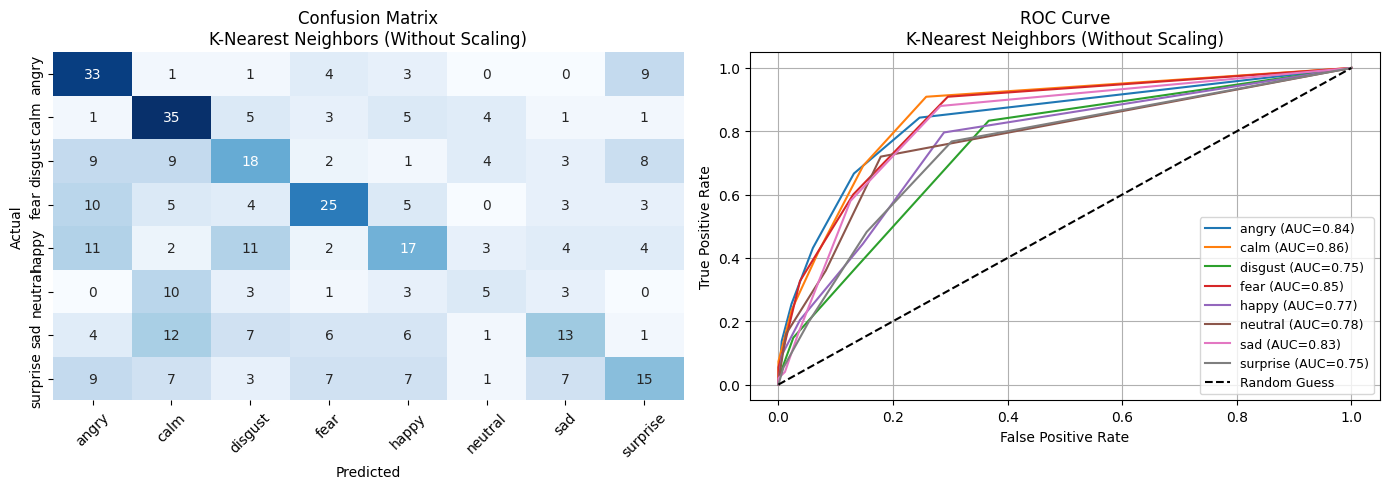


Training: Neural Network (MLP) (Without Scaling)


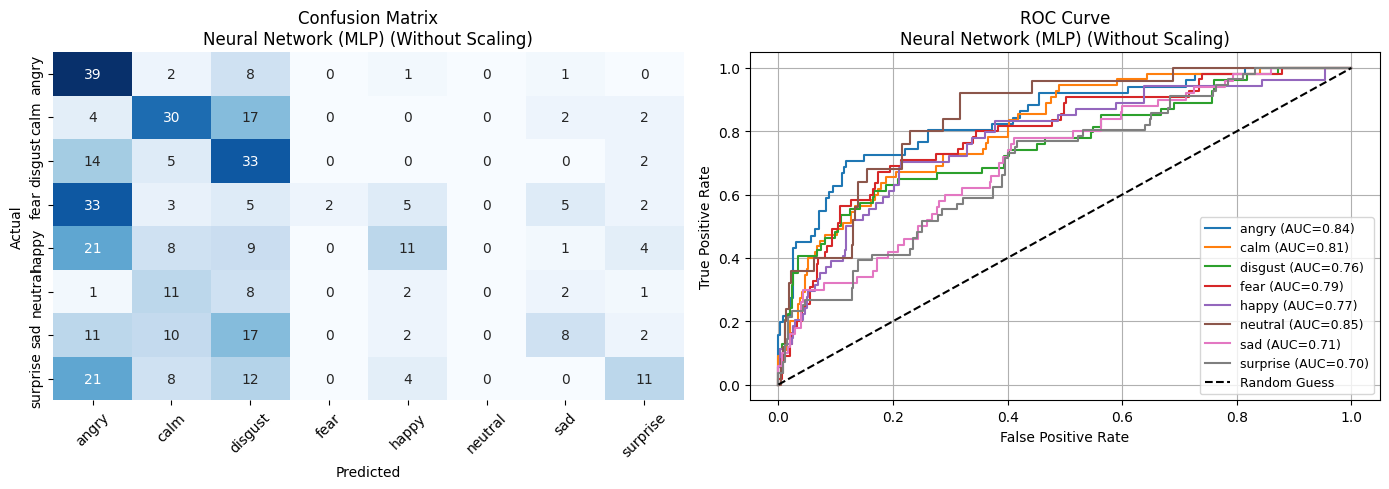


Training: AdaBoost (Without Scaling)


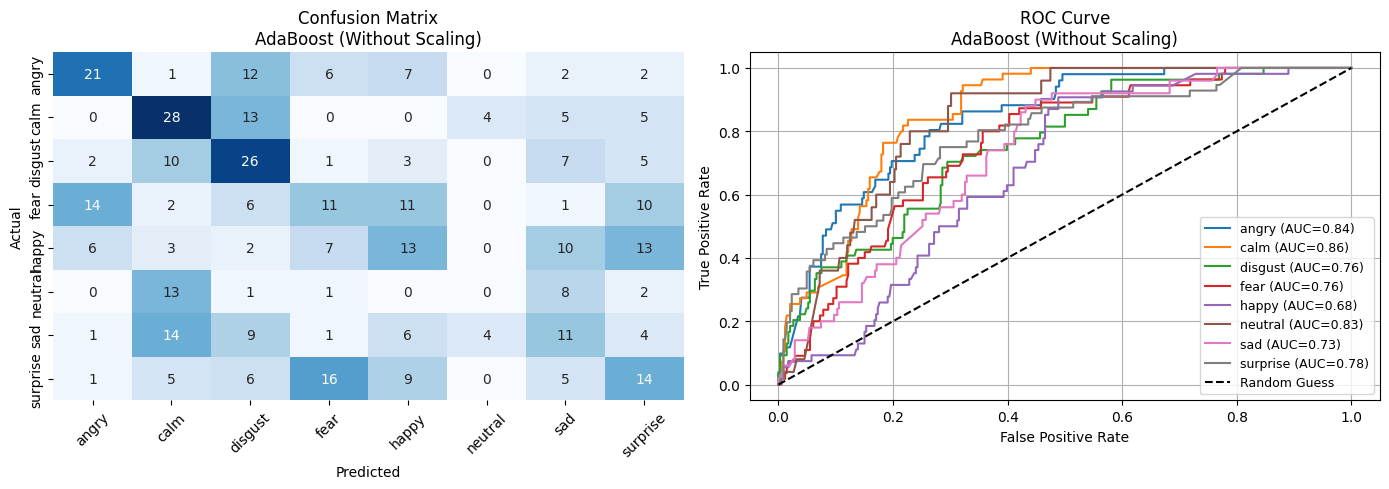


Training: Bagging (Without Scaling)


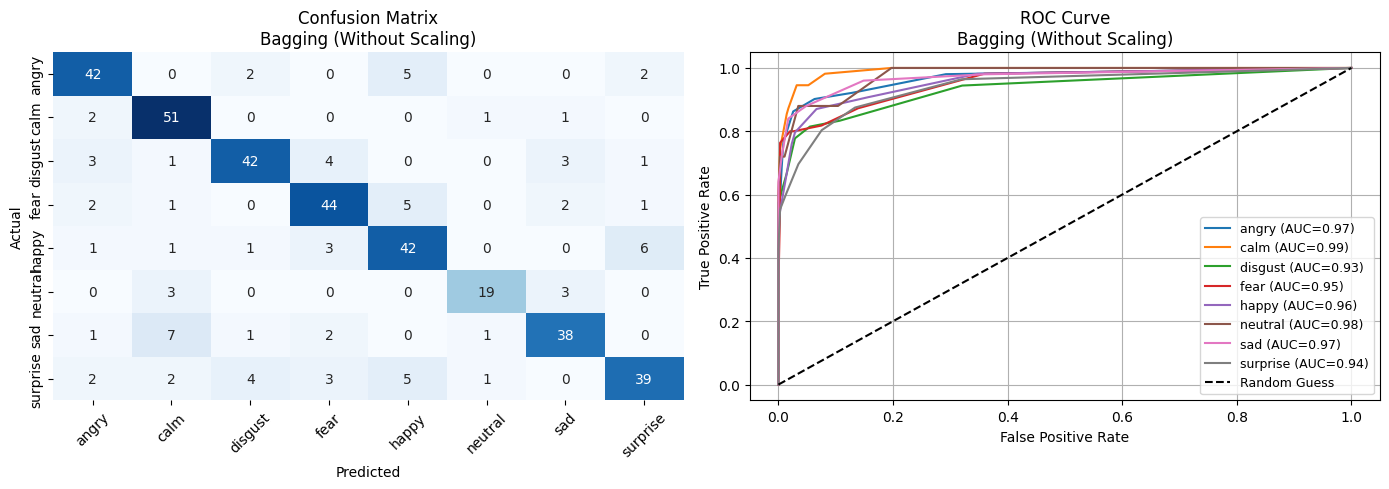


Training: Naive Bayes (Without Scaling)


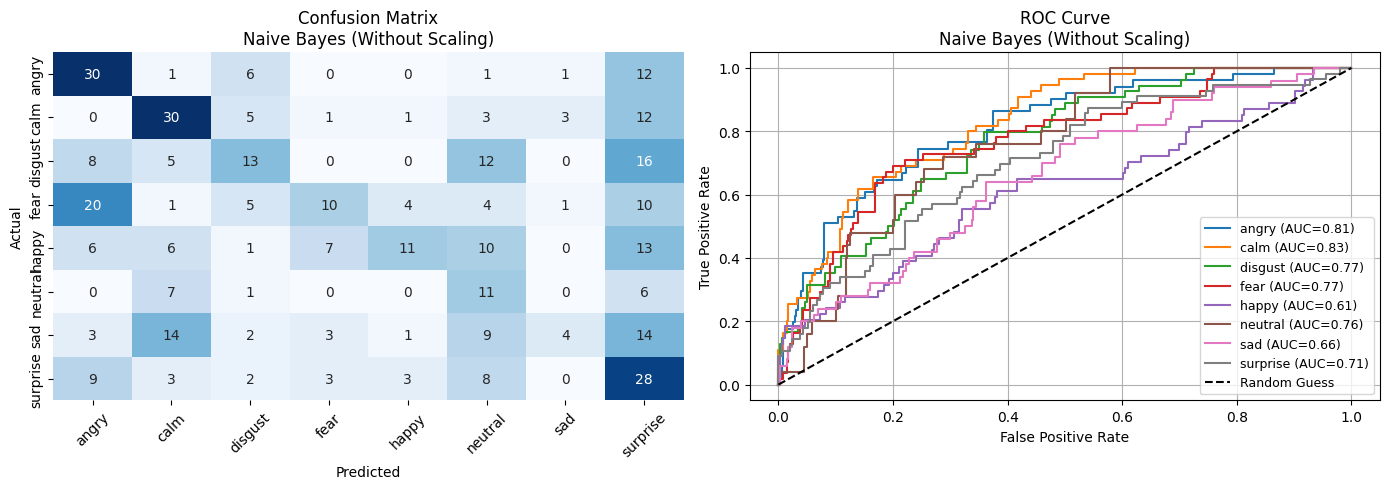


Training: QDA (Without Scaling)


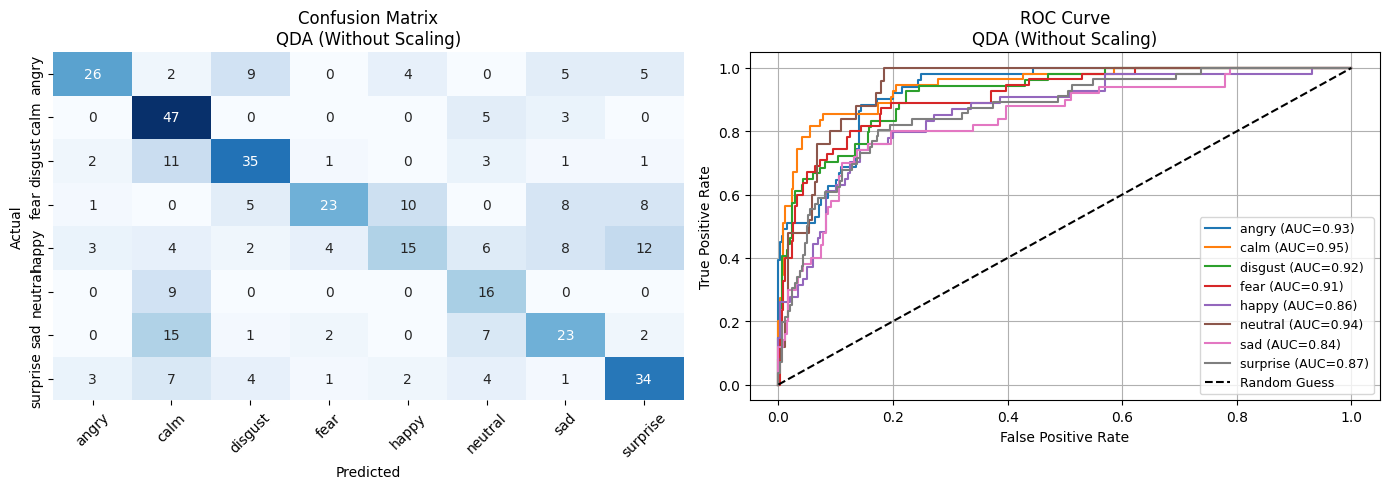

In [20]:
results_df = train_evaluate_and_plot(X_train, X_test, y_train, y_test, label_suffix=" (Without Scaling)")

## Modelling and Evaluation with ***RobustScaler***

### Split Train and Test Data with ***RobustScaler***

In [22]:
from sklearn.preprocessing import RobustScaler

# Apply robust scaling to handle outliers better than standard scaling
robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)

# Train-test split after scaling
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(
    X_robust_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
X_train_robust.shape

(1600, 19)

In [24]:
X_test_robust.shape

(400, 19)

In [25]:
y_train_robust.shape

(1600,)

In [26]:
y_test_robust.shape

(400,)

### Train models and plot results with ***RobustScaler***


Training: Logistic Regression (RobustScaled)


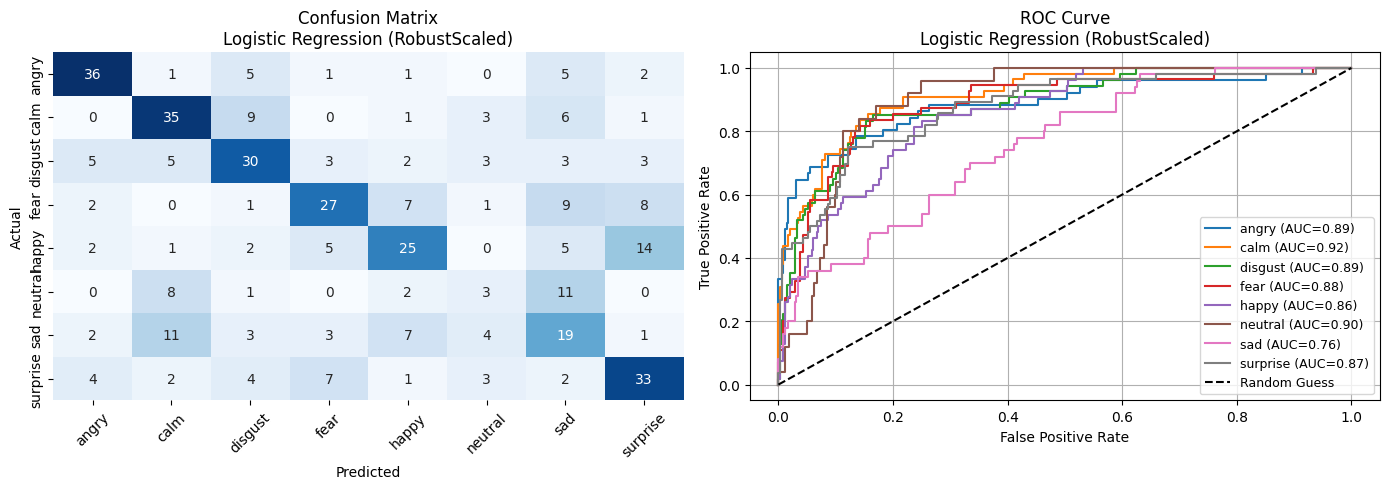


Training: Random Forest (RobustScaled)


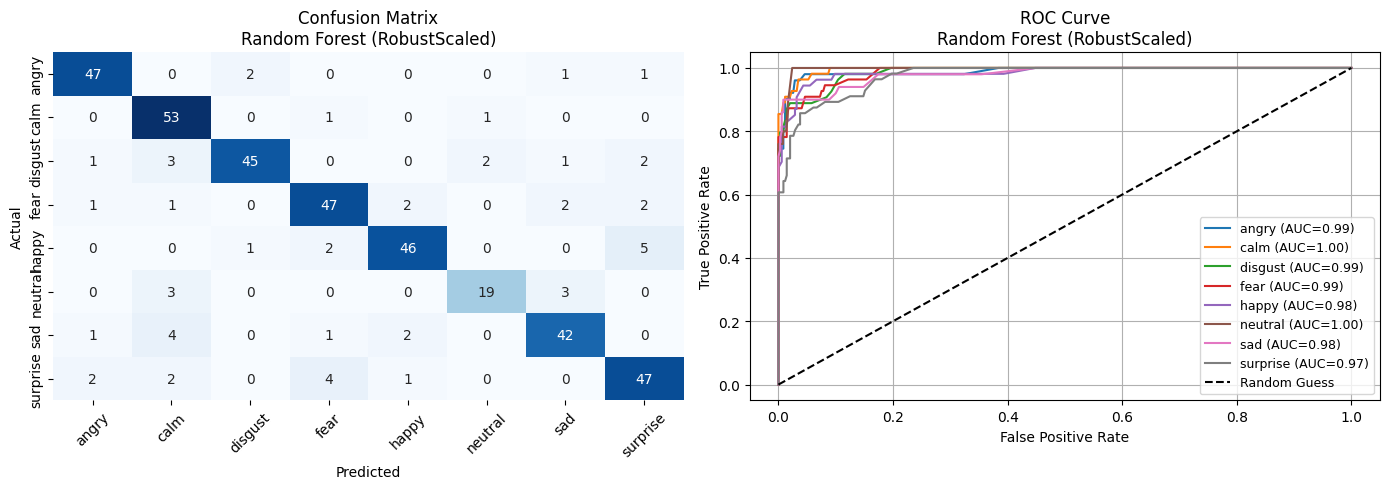


Training: Decision Tree (RobustScaled)


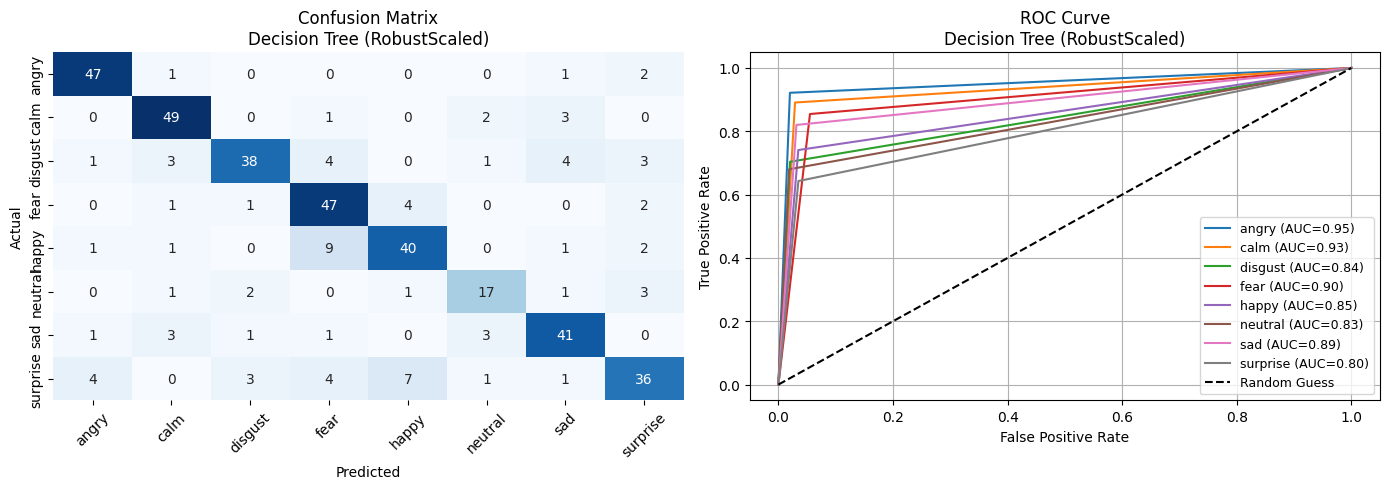


Training: Gradient Boosting (RobustScaled)


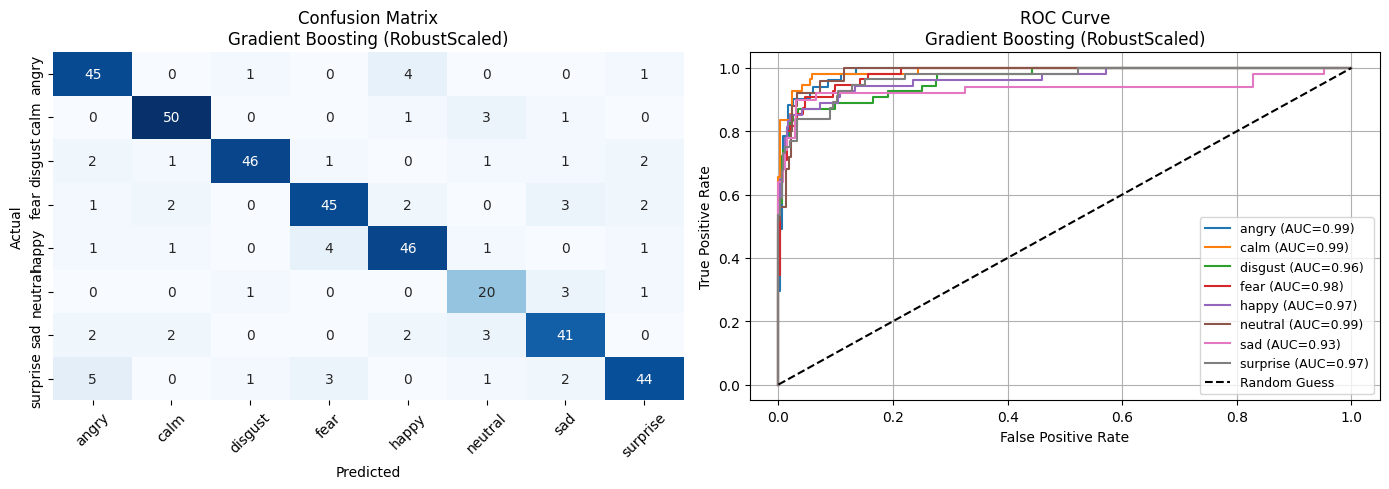


Training: HistGradient Boosting (RobustScaled)


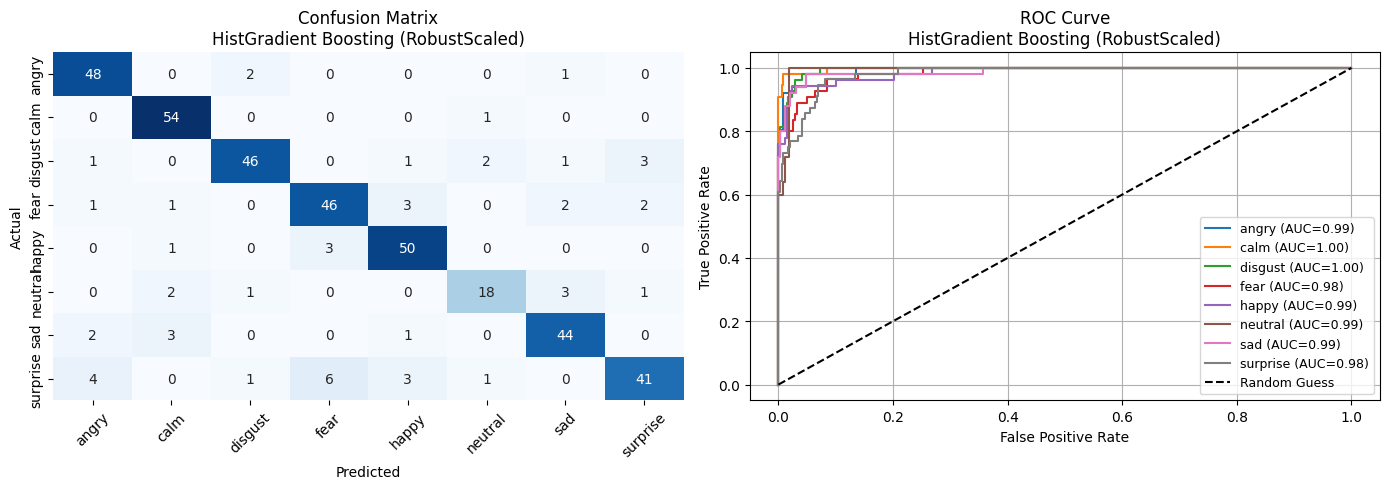


Training: XGBoost (RobustScaled)


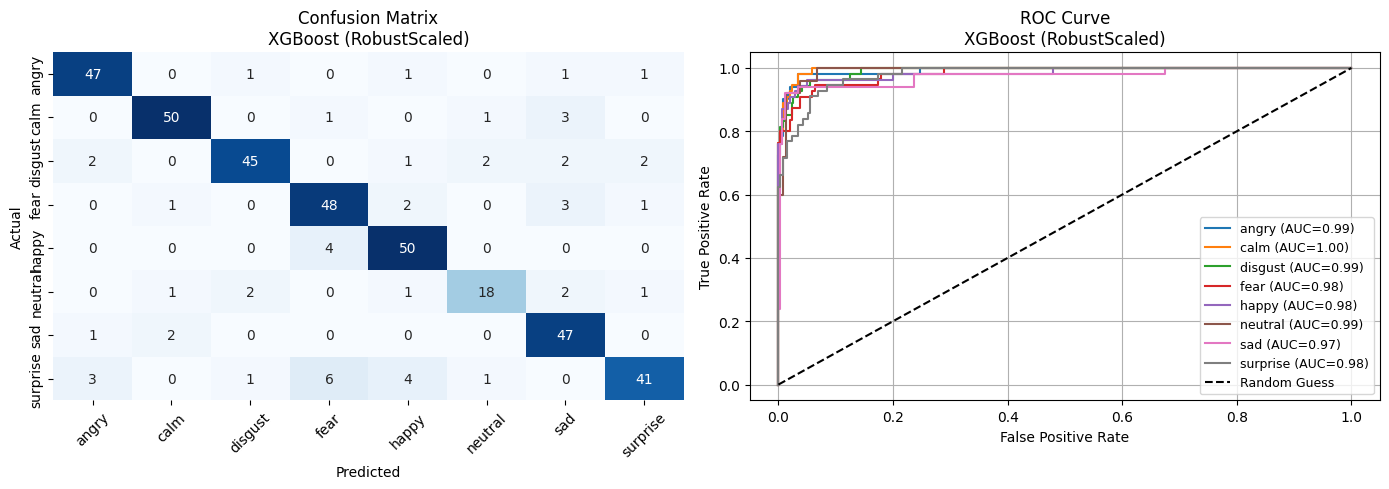


Training: CatBoost (RobustScaled)


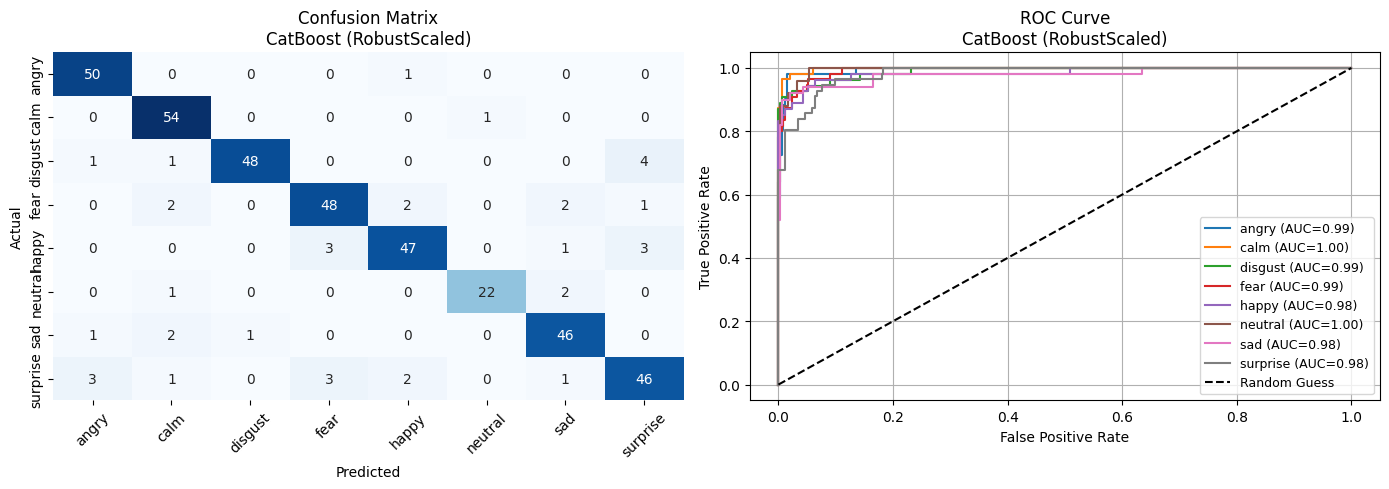


Training: K-Nearest Neighbors (RobustScaled)


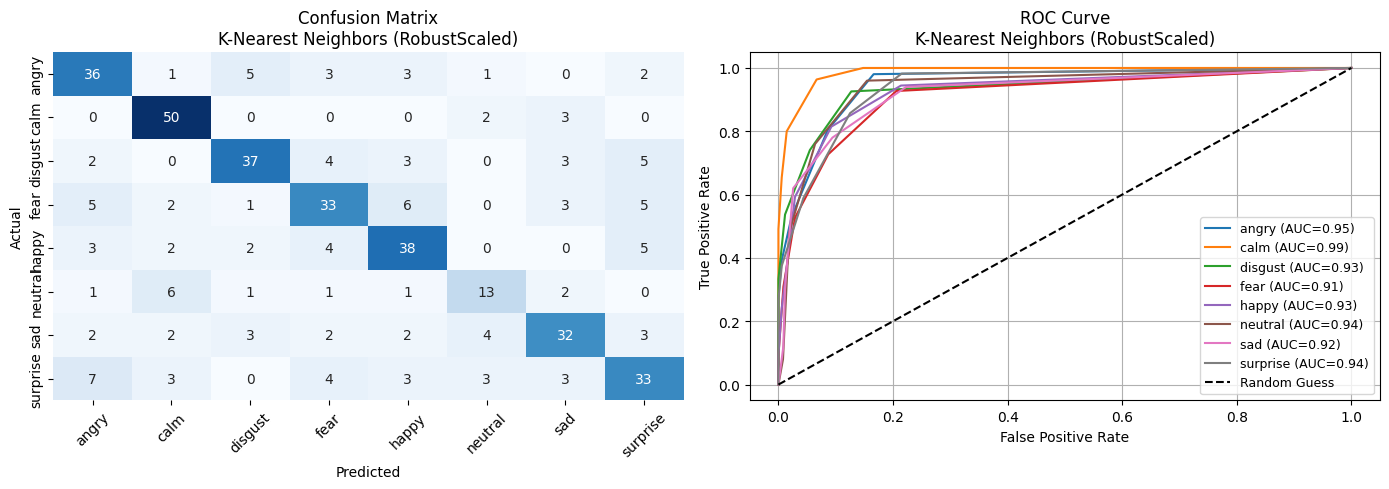


Training: Neural Network (MLP) (RobustScaled)


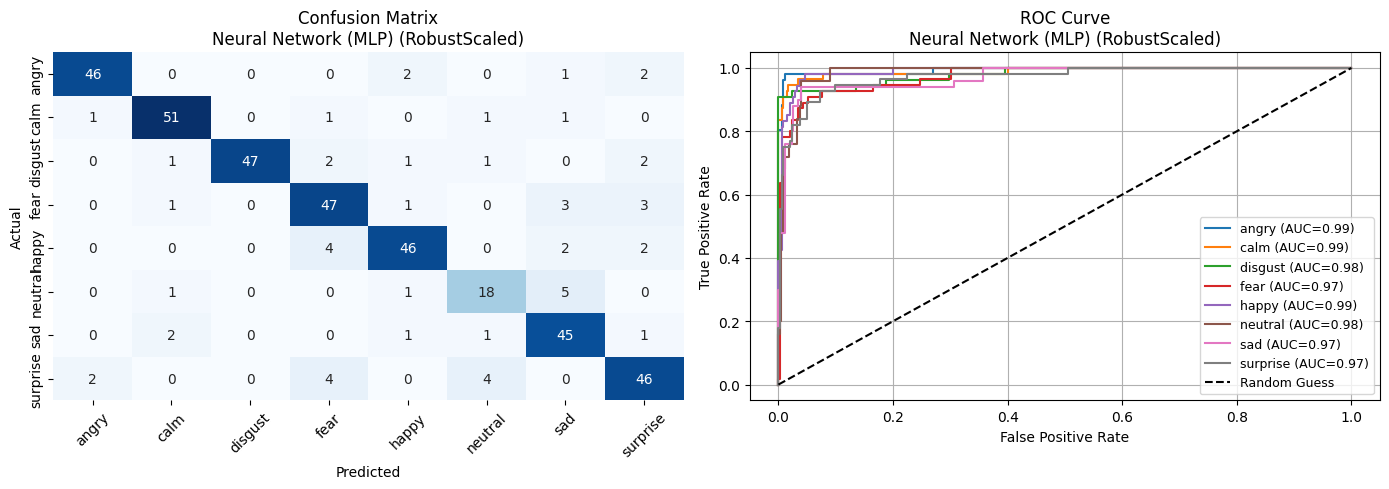


Training: AdaBoost (RobustScaled)


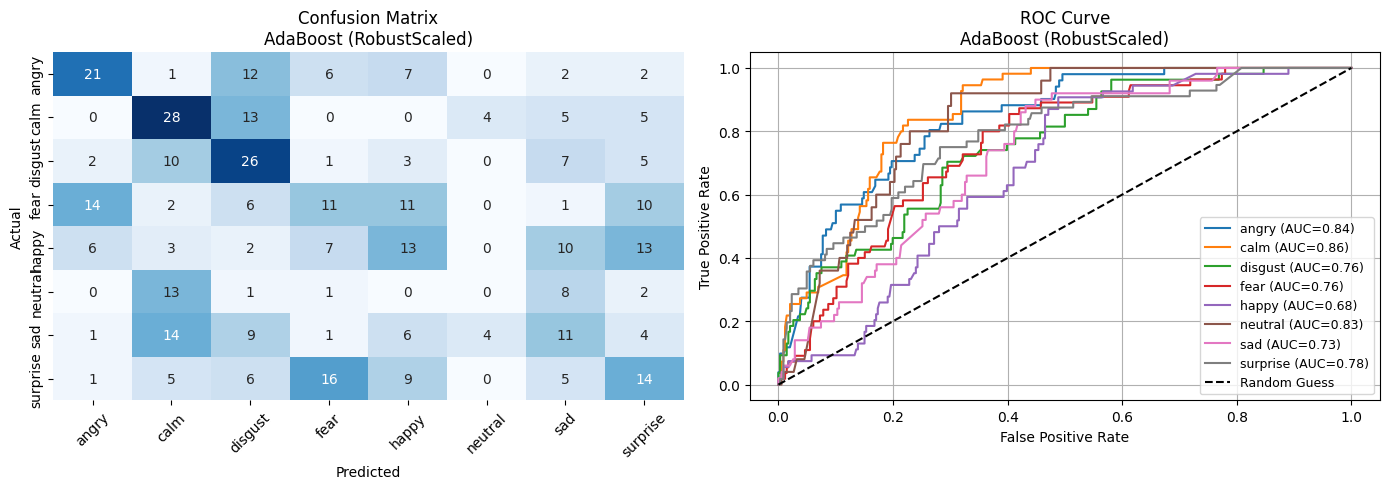


Training: Bagging (RobustScaled)


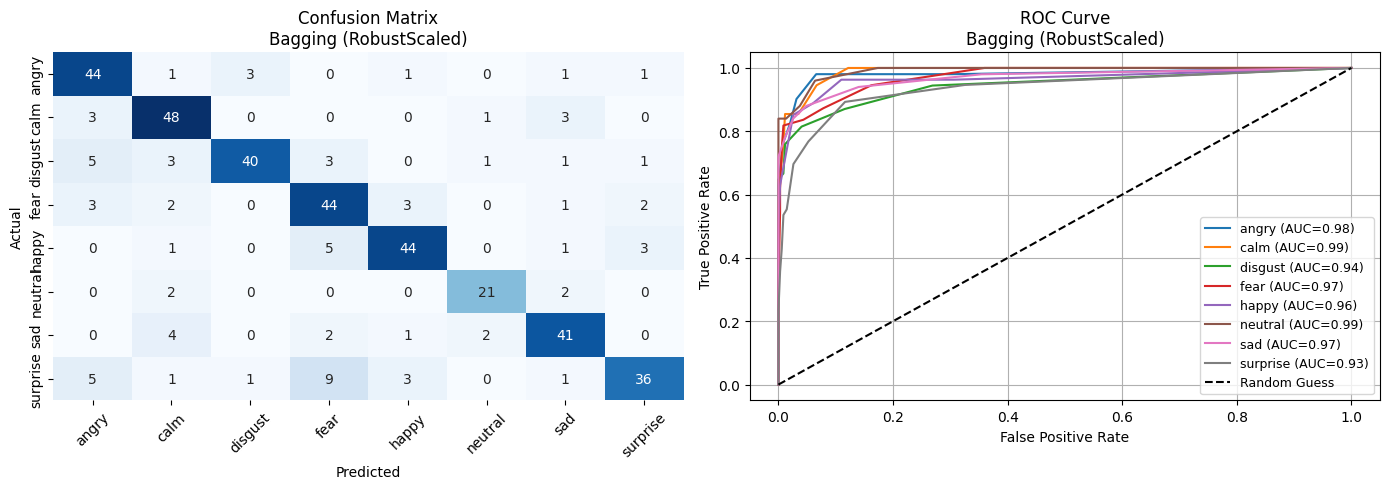


Training: Naive Bayes (RobustScaled)


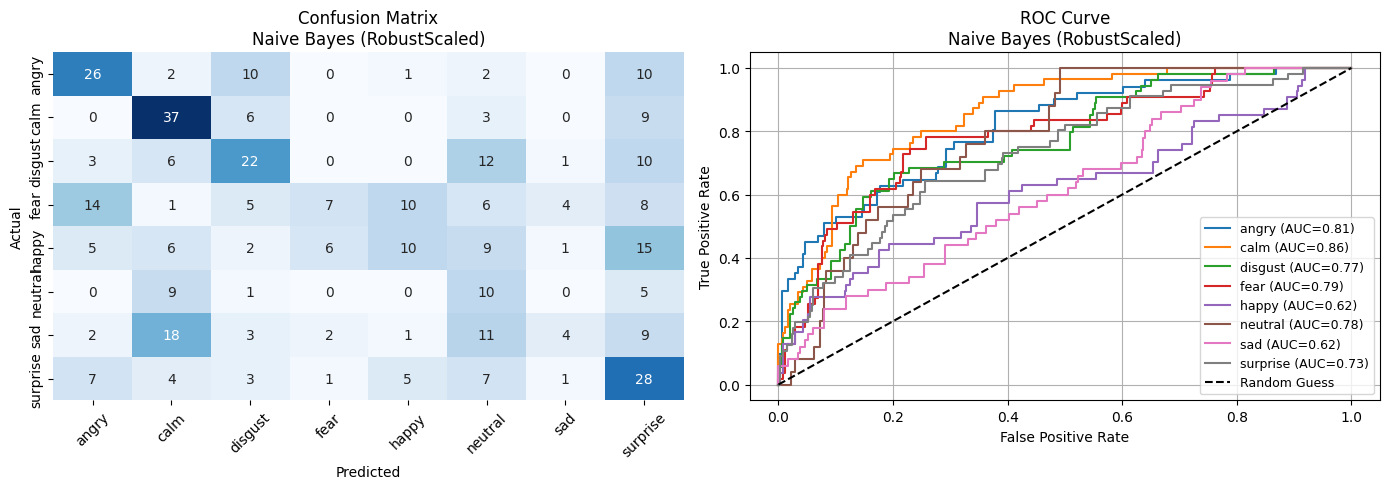


Training: QDA (RobustScaled)


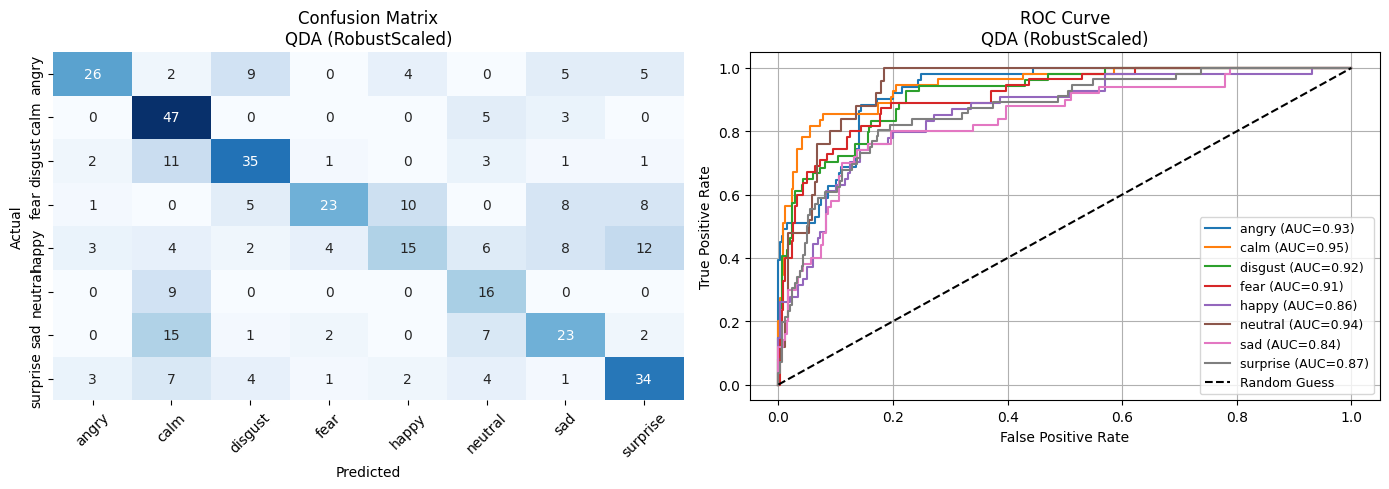

In [27]:
results_robust = train_evaluate_and_plot(X_train_robust, X_test_robust, y_train_robust, y_test_robust, label_suffix=" (RobustScaled)")

# Visualization of all models (without ***RobustScaler*** and with ***RobustScaler***)

In [28]:
# Combine with previous results
all_model_results = pd.concat([results_df, results_robust])

In [29]:
all_model_results

Model    Set  Accuracy      Loss  \
0     Logistic Regression (Without Scaling)  Train  0.452500  0.547500   
1     Logistic Regression (Without Scaling)   Test  0.417500  0.582500   
2           Random Forest (Without Scaling)  Train  1.000000  0.000000   
3           Random Forest (Without Scaling)   Test  0.840000  0.160000   
4           Decision Tree (Without Scaling)  Train  1.000000  0.000000   
5           Decision Tree (Without Scaling)   Test  0.787500  0.212500   
6       Gradient Boosting (Without Scaling)  Train  0.994375  0.005625   
7       Gradient Boosting (Without Scaling)   Test  0.827500  0.172500   
8   HistGradient Boosting (Without Scaling)  Train  1.000000  0.000000   
9   HistGradient Boosting (Without Scaling)   Test  0.867500  0.132500   
10                XGBoost (Without Scaling)  Train  1.000000  0.000000   
11                XGBoost (Without Scaling)   Test  0.865000  0.135000   
12               CatBoost (Without Scaling)  Train  1.000000  0.000000   
13               CatBoost (Without Scaling)   Test  0.902500  0.097500   
14    K-Nearest Neighbors (Without Scaling)  Train  0.624375  0.375625   
15    K-Nearest Neighbors (Without Scaling)   Test  0.402500  0.597500   
16   Neural Network (MLP) (Without Scaling)  Train  0.378750  0.621250   
17   Neural Network (MLP) (Without Scaling)   Test  0.335000  0.665000   
18               AdaBoost (Without Scaling)  Train  0.393750  0.606250   
19               AdaBoost (Without Scaling)   Test  0.310000  0.690000   
20                Bagging (Without Scaling)  Train  0.995625  0.004375   
21                Bagging (Without Scaling)   Test  0.792500  0.207500   
22            Naive Bayes (Without Scaling)  Train  0.365000  0.635000   
23            Naive Bayes (Without Scaling)   Test  0.342500  0.657500   
24                    QDA (Without Scaling)  Train  0.652500  0.347500   
25                    QDA (Without Scaling)   Test  0.547500  0.452500   
0        Logistic Regression (RobustScaled)  Train  0.568125  0.431875   
1        Logistic Regression (RobustScaled)   Test  0.520000  0.480000   
2              Random Forest (RobustScaled)  Train  1.000000  0.000000   
3              Random Forest (RobustScaled)   Test  0.865000  0.135000   
4              Decision Tree (RobustScaled)  Train  1.000000  0.000000   
5              Decision Tree (RobustScaled)   Test  0.787500  0.212500   
6          Gradient Boosting (RobustScaled)  Train  0.996250  0.003750   
7          Gradient Boosting (RobustScaled)   Test  0.842500  0.157500   
8      HistGradient Boosting (RobustScaled)  Train  1.000000  0.000000   
9      HistGradient Boosting (RobustScaled)   Test  0.867500  0.132500   
10                   XGBoost (RobustScaled)  Train  1.000000  0.000000   
11                   XGBoost (RobustScaled)   Test  0.865000  0.135000   
12                  CatBoost (RobustScaled)  Train  1.000000  0.000000   
13                  CatBoost (RobustScaled)   Test  0.902500  0.097500   
14       K-Nearest Neighbors (RobustScaled)  Train  0.835000  0.165000   
15       K-Nearest Neighbors (RobustScaled)   Test  0.680000  0.320000   
16      Neural Network (MLP) (RobustScaled)  Train  0.990000  0.010000   
17      Neural Network (MLP) (RobustScaled)   Test  0.865000  0.135000   
18                  AdaBoost (RobustScaled)  Train  0.393750  0.606250   
19                  AdaBoost (RobustScaled)   Test  0.310000  0.690000   
20                   Bagging (RobustScaled)  Train  0.994375  0.005625   
21                   Bagging (RobustScaled)   Test  0.795000  0.205000   
22               Naive Bayes (RobustScaled)  Train  0.393750  0.606250   
23               Naive Bayes (RobustScaled)   Test  0.360000  0.640000   
24                       QDA (RobustScaled)  Train  0.652500  0.347500   
25                       QDA (RobustScaled)   Test  0.547500  0.452500   

    Precision    Recall  F1 Score  
0    0.451696  0.452500  0.447965  
1    0.422589  0.417500  0.415770  
2    1.

## Visualization Using Grouped Horizontal Bar Plot

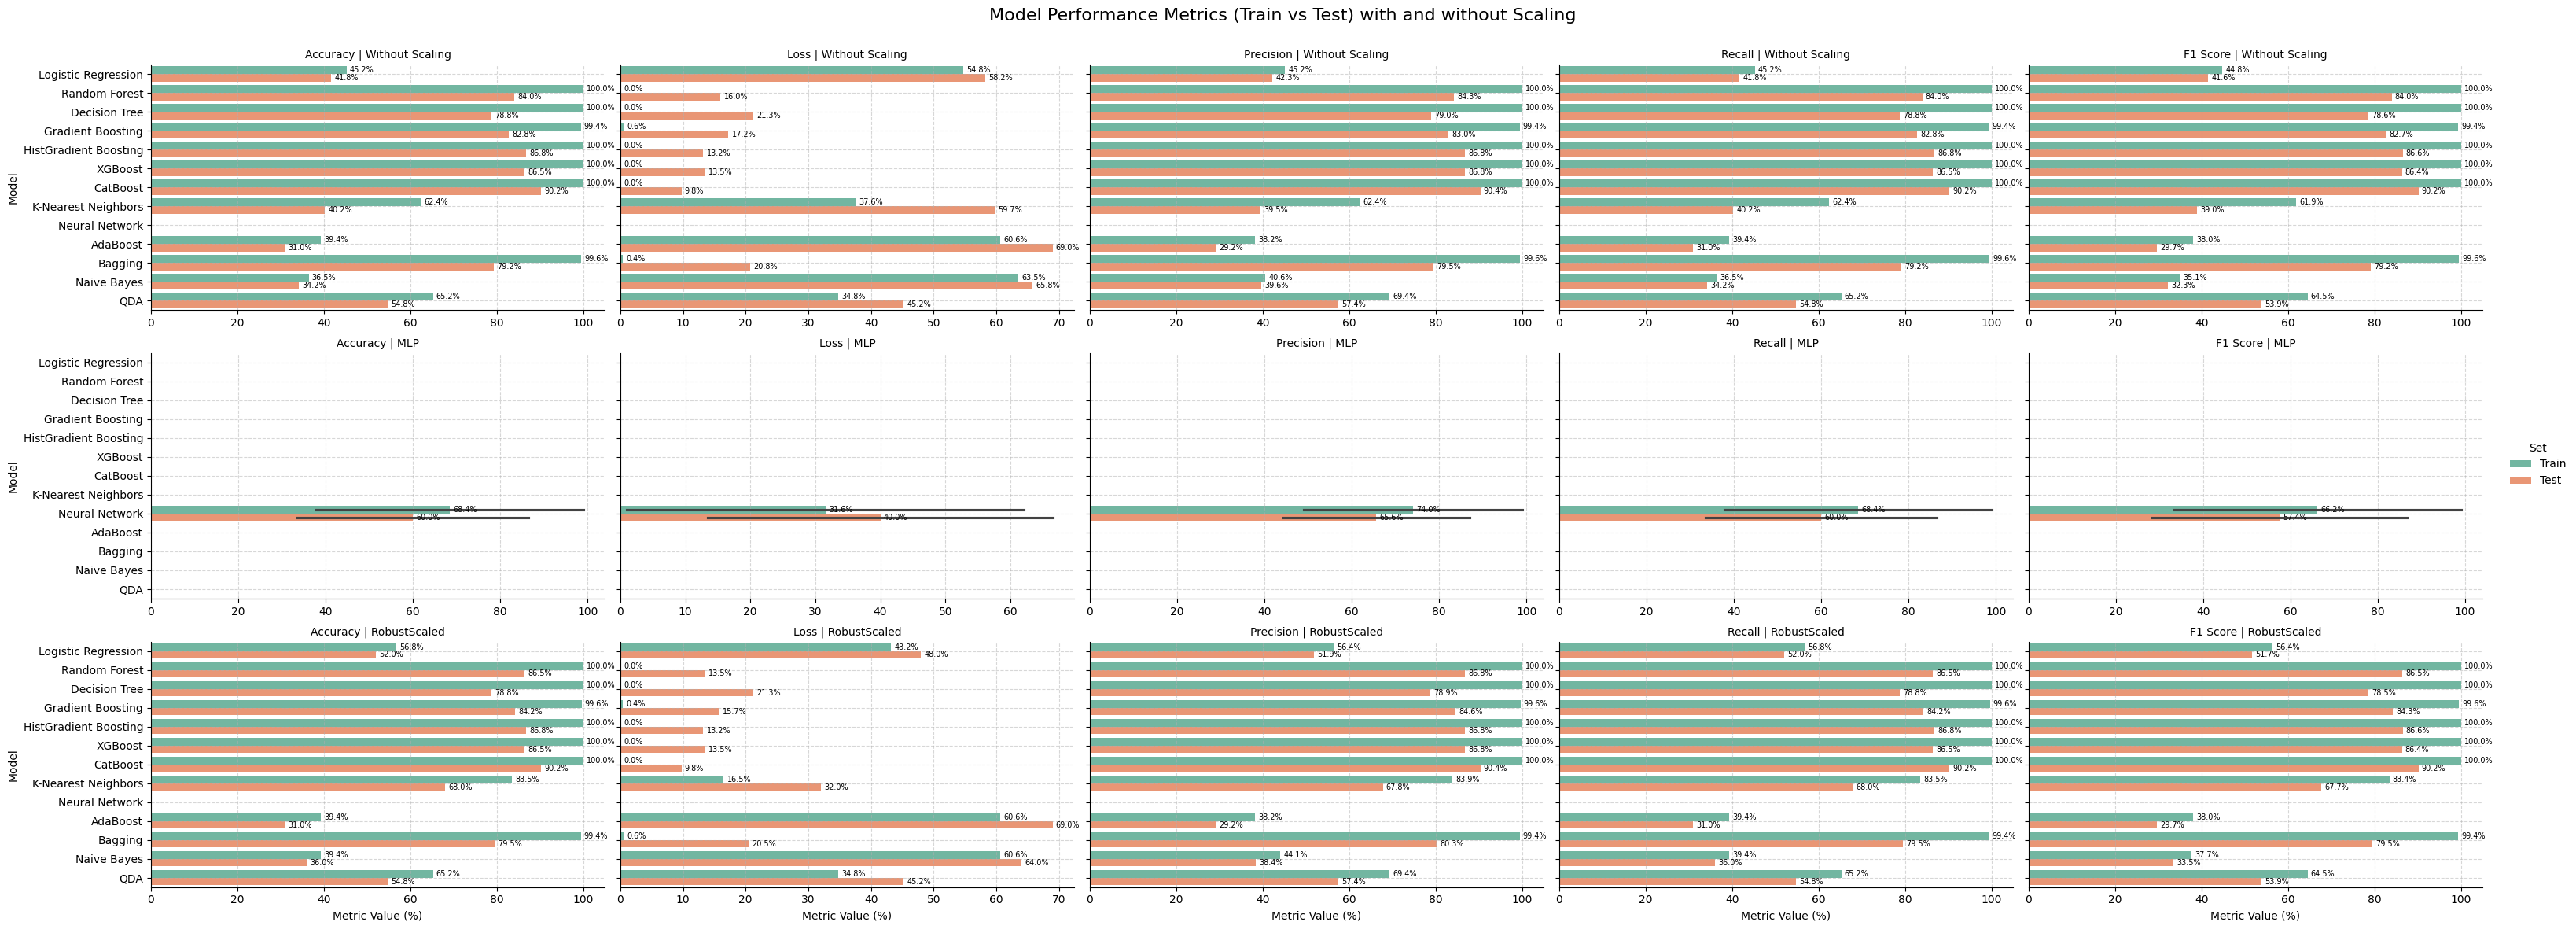

In [31]:
# Filter only the test and train results
filtered_results = all_model_results.copy()

# Extract the base model names without scaling suffix
filtered_results['BaseModel'] = filtered_results['Model'].str.replace(r' \(.*\)', '', regex=True)
filtered_results['Scaling'] = filtered_results['Model'].str.extract(r'\((.*?)\)')[0].fillna("No Scaling")

# Melt the results DataFrame to long format for plotting
melted_results = pd.melt(
    filtered_results,
    id_vars=['BaseModel', 'Scaling', 'Set'],
    value_vars=['Accuracy', 'Loss', 'Precision', 'Recall', 'F1 Score'],
    var_name='Metric',
    value_name='Value'
)

# Convert to percentage for consistency
melted_results['Value'] = melted_results['Value'] * 100

# Create a FacetGrid for better separation
g = sns.catplot(
    data=melted_results,
    kind="bar",
    x="Value",
    y="BaseModel",
    hue="Set",
    col="Metric",
    row="Scaling",
    height=4,
    aspect=1.6,
    palette="Set2",
    sharex=False
)

# Format each axis
g.set_titles("{col_name} | {row_name}")
g.set_axis_labels("Metric Value (%)", "Model")
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3, fontsize=7)

plt.subplots_adjust(top=0.92)
g.fig.suptitle("Model Performance Metrics (Train vs Test) with and without Scaling", fontsize=16)
plt.show()


##  Line Plot: Metric Trends per Model

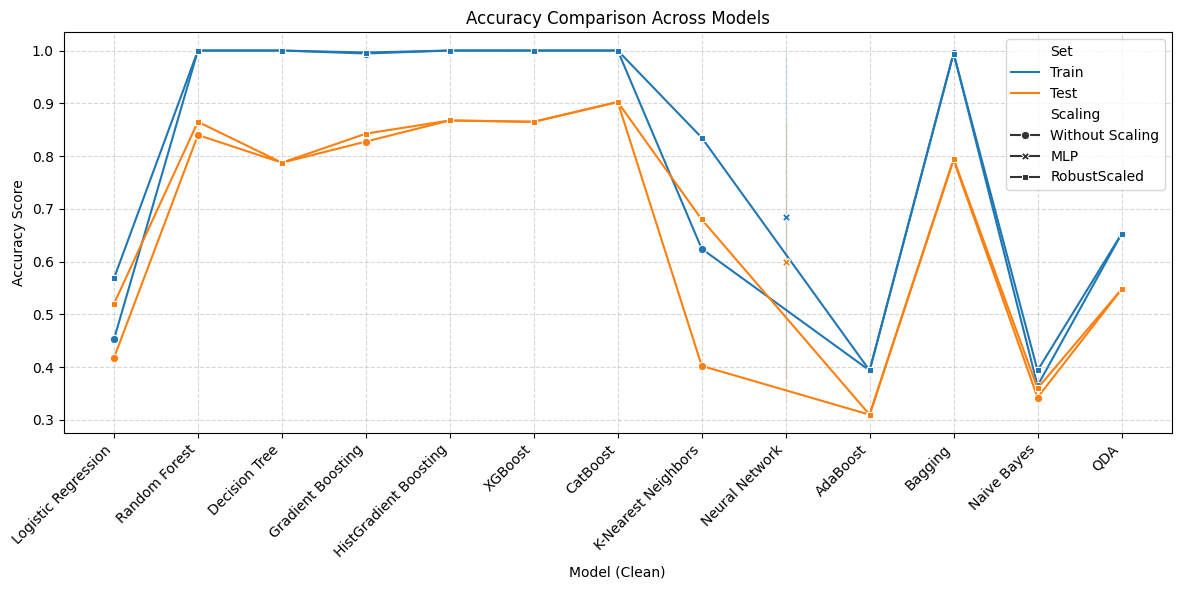

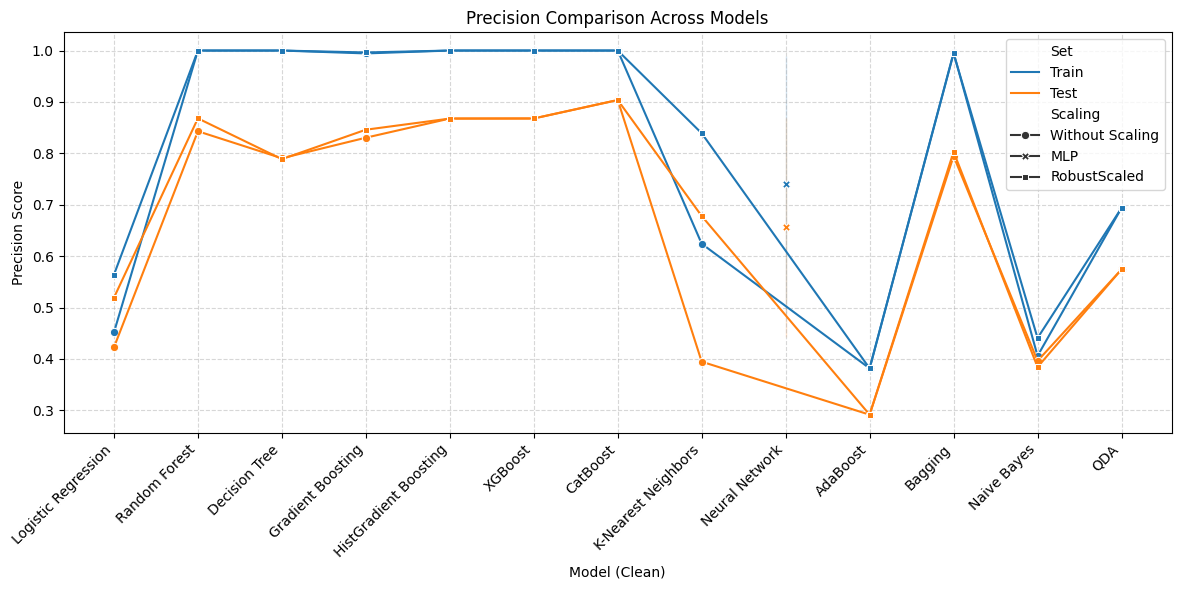

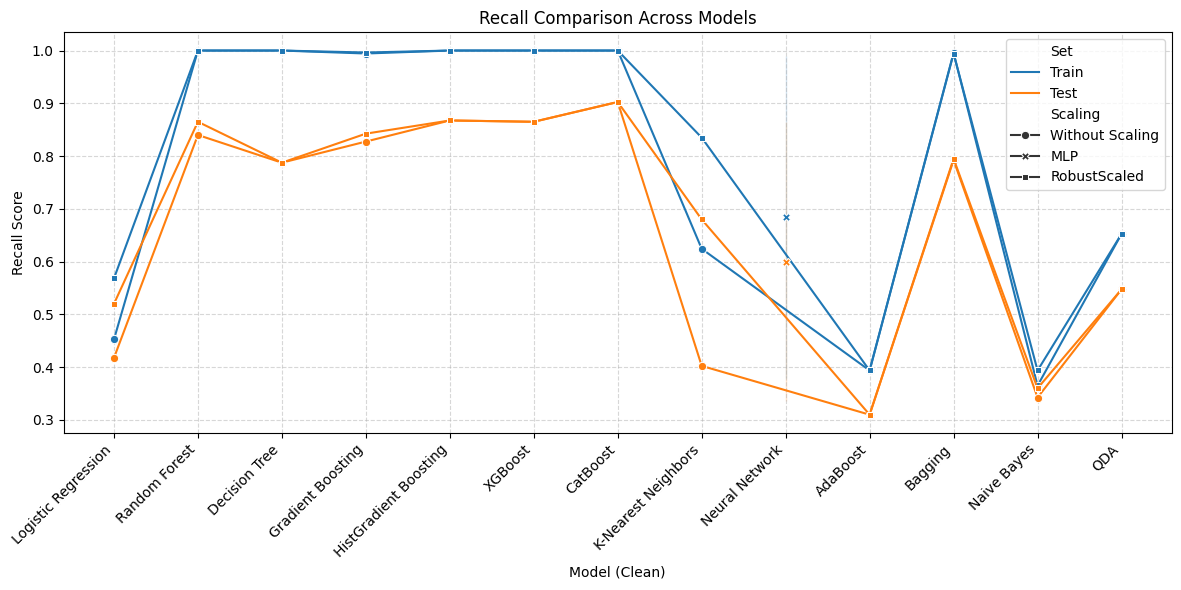

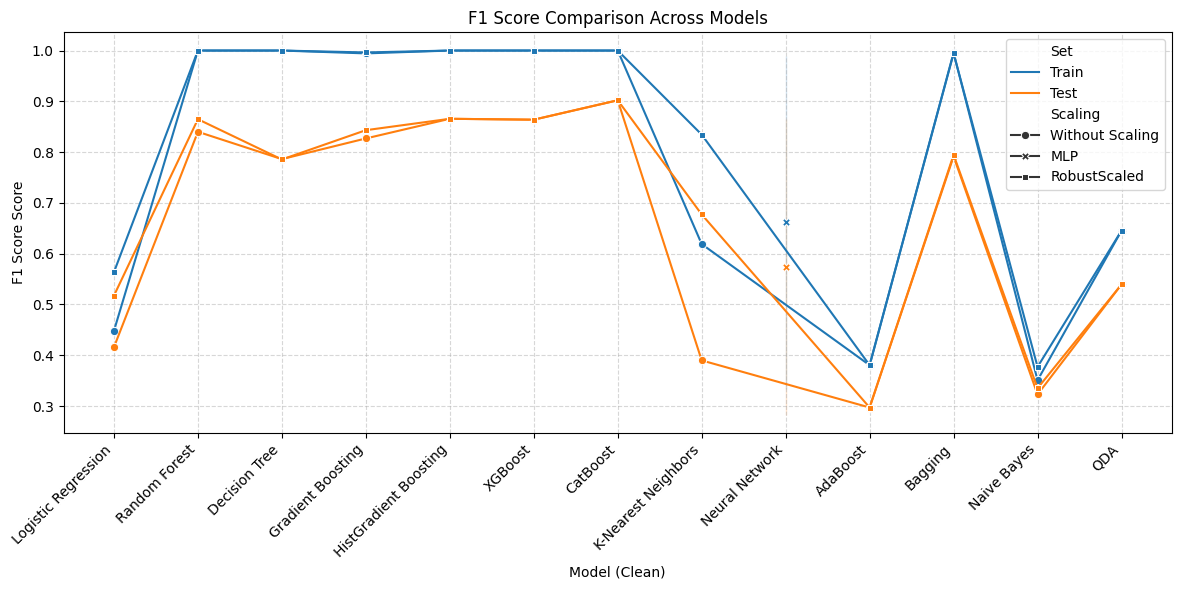

In [33]:
line_data = all_model_results.copy()
line_data['Model (Clean)'] = line_data['Model'].str.replace(r' \((.*?)\)', '', regex=True)
line_data['Scaling'] = line_data['Model'].str.extract(r'\((.*?)\)')[0].fillna('No Scaling')

# Plot for each metric
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=line_data, x='Model (Clean)', y=metric, hue='Set', style='Scaling', markers=True, dashes=False)
    plt.title(f'{metric} Comparison Across Models')
    plt.ylabel(f'{metric} Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Heatmap of Metrics

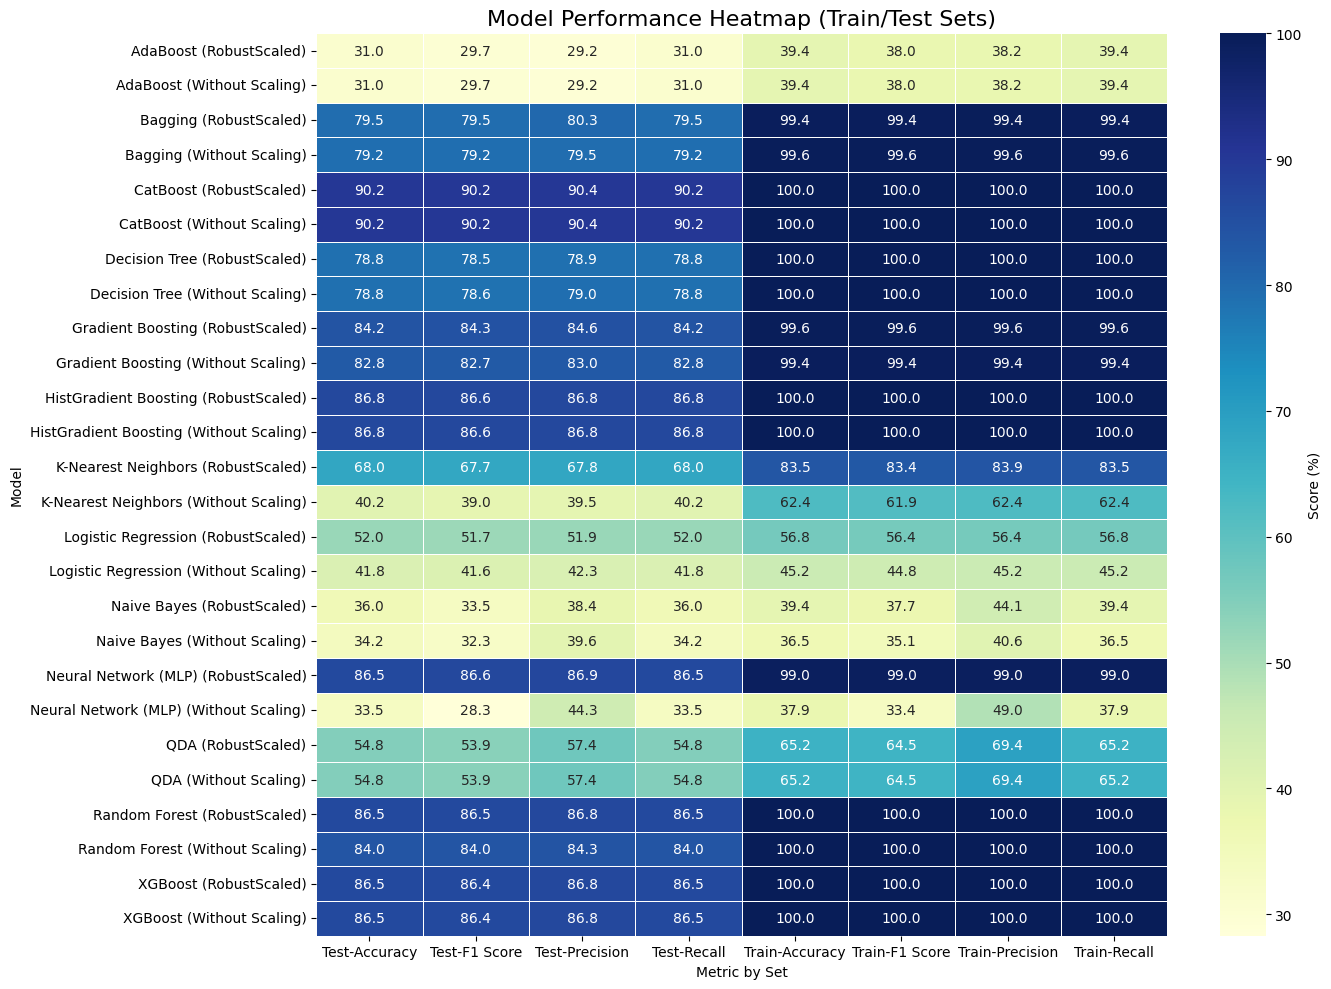

In [34]:
# Prepare data pivoted by model and metric
heatmap_data = all_model_results.pivot_table(
    index='Model',
    columns='Set',
    values=['Accuracy', 'Precision', 'Recall', 'F1 Score']
)

# Normalize to percentage
heatmap_data *= 100

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data.swaplevel(axis=1).sort_index(axis=1),
            annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Score (%)'})
plt.title("Model Performance Heatmap (Train/Test Sets)", fontsize=16)
plt.ylabel("Model")
plt.xlabel("Metric by Set")
plt.tight_layout()
plt.show()

# Deep Learning Modelling and Evaluation

In [35]:
# One-hot encode the robust scaled targets
y_train_robust_nn = to_categorical(y_train_robust)
y_test_robust_nn = to_categorical(y_test_robust)

In [36]:
# Store training histories for later plotting/comparison
nn_training_histories = []

## Model 1: Basic NN with Dropout

In [37]:
basic_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_robust.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_robust_nn.shape[1], activation='softmax')
])

basic_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_basic = basic_nn.fit(
    X_train_robust, y_train_robust_nn,
    validation_data=(X_test_robust, y_test_robust_nn),
    epochs=50, batch_size=16, verbose=1
)

nn_training_histories.append(('BasicNN_Dropout', history_basic))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1784 - loss: 2.0460 - val_accuracy: 0.3400 - val_loss: 1.7581
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3545 - loss: 1.7120 - val_accuracy: 0.4125 - val_loss: 1.5697
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4066 - loss: 1.5420 - val_accuracy: 0.4525 - val_loss: 1.4570
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4560 - loss: 1.4724 - val_accuracy: 0.4800 - val_loss: 1.3918
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4390 - loss: 1.4565 - val_accuracy: 0.5050 - val_loss: 1.3533
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5005 - loss: 1.3455 - val_accuracy: 0.5275 - val_loss: 1.3192
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5039 - loss: 1.2945 - val_accuracy: 0.5075 - val_loss: 1.2738
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5422 - loss: 1.2167 - val_accuracy: 0.

## Model 2: Deeper Network with Regularized Dropout

In [38]:
deep_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_robust.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_robust_nn.shape[1], activation='softmax')
])

deep_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_deep = deep_nn.fit(
    X_train_robust, y_train_robust_nn,
    validation_data=(X_test_robust, y_test_robust_nn),
    epochs=50, batch_size=16, verbose=1
)

nn_training_histories.append(('DeepNN_Regularized', history_deep))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2079 - loss: 2.0363 - val_accuracy: 0.3500 - val_loss: 1.7651
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3569 - loss: 1.7544 - val_accuracy: 0.4525 - val_loss: 1.5023
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4208 - loss: 1.5360 - val_accuracy: 0.4600 - val_loss: 1.4205
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4867 - loss: 1.4167 - val_accuracy: 0.5250 - val_loss: 1.3206
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4722 - loss: 1.3644 - val_accuracy: 0.5325 - val_loss: 1.2736
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5212 - loss: 1.2692 - val_accuracy: 0.5725 - val_loss: 1.2064
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5391 - loss: 1.2472 - val_accuracy: 0.5975 - val_loss: 1.1505
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5594 - loss: 1.2295 - val_accuracy: 0.

We compared multiple ML models:

Classical ML models: Logistic Regression, Random Forest, Extra Trees, SVM (Linear & RBF), KNN, XGBoost, LightGBM, AdaBoost, Naive Bayes, etc.

Neural Networks:

Shallow and deep fully-connected NNs with Dropout and Batch Normalization

Trained using categorical crossentropy loss and softmax activation

Model evaluation included:

Accuracy, Precision, Recall, F1 Score

Confusion matrices

ROC-AUC curves

# Visualization of Deep Learning Models

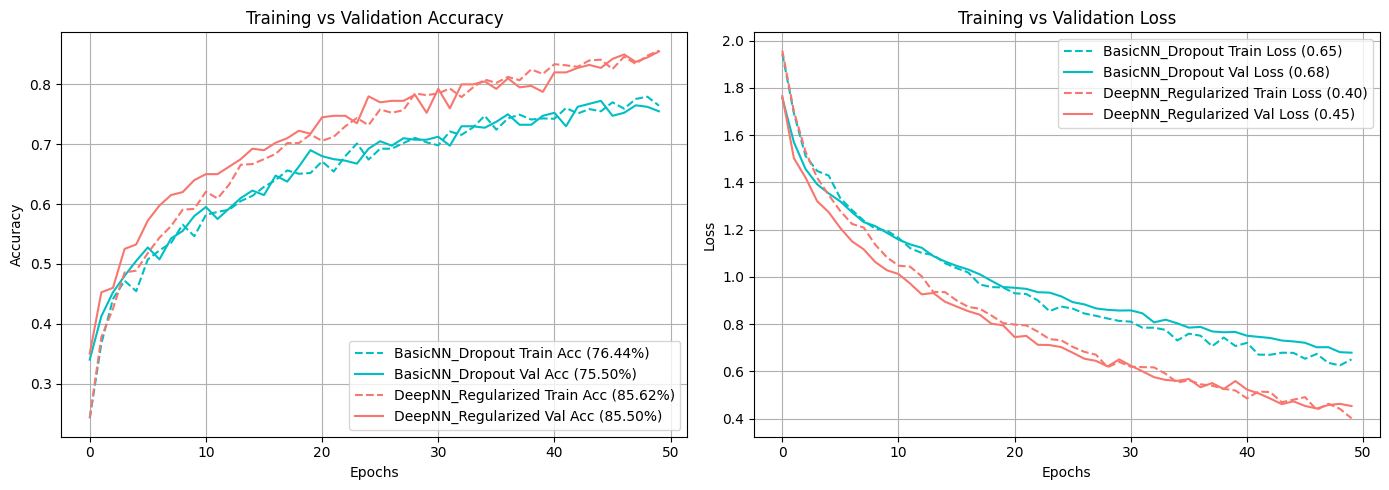

In [39]:
# color cycle
custom_colors = itertools.cycle(['#00BFC4', '#F8766D', '#7CAE00', '#C77CFF', '#FF61C3', '#00BA38', '#619CFF'])

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
for model_name, hist in nn_training_histories:
    color = next(custom_colors)
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(train_acc, linestyle='--', label=f'{model_name} Train Acc ({train_acc[-1]*100:.2f}%)', color=color)
    plt.plot(val_acc, linestyle='-', label=f'{model_name} Val Acc ({val_acc[-1]*100:.2f}%)', color=color)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# color cycle for Loss Plot
custom_colors = itertools.cycle(['#00BFC4', '#F8766D', '#7CAE00', '#C77CFF', '#FF61C3', '#00BA38', '#619CFF'])

# Loss Plot
plt.subplot(1, 2, 2)
for model_name, hist in nn_training_histories:
    color = next(custom_colors)
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(train_loss, linestyle='--', label=f'{model_name} Train Loss ({train_loss[-1]:.2f})', color=color)
    plt.plot(val_loss, linestyle='-', label=f'{model_name} Val Loss ({val_loss[-1]:.2f})', color=color)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Area Plot (Shaded Epoch Curves)

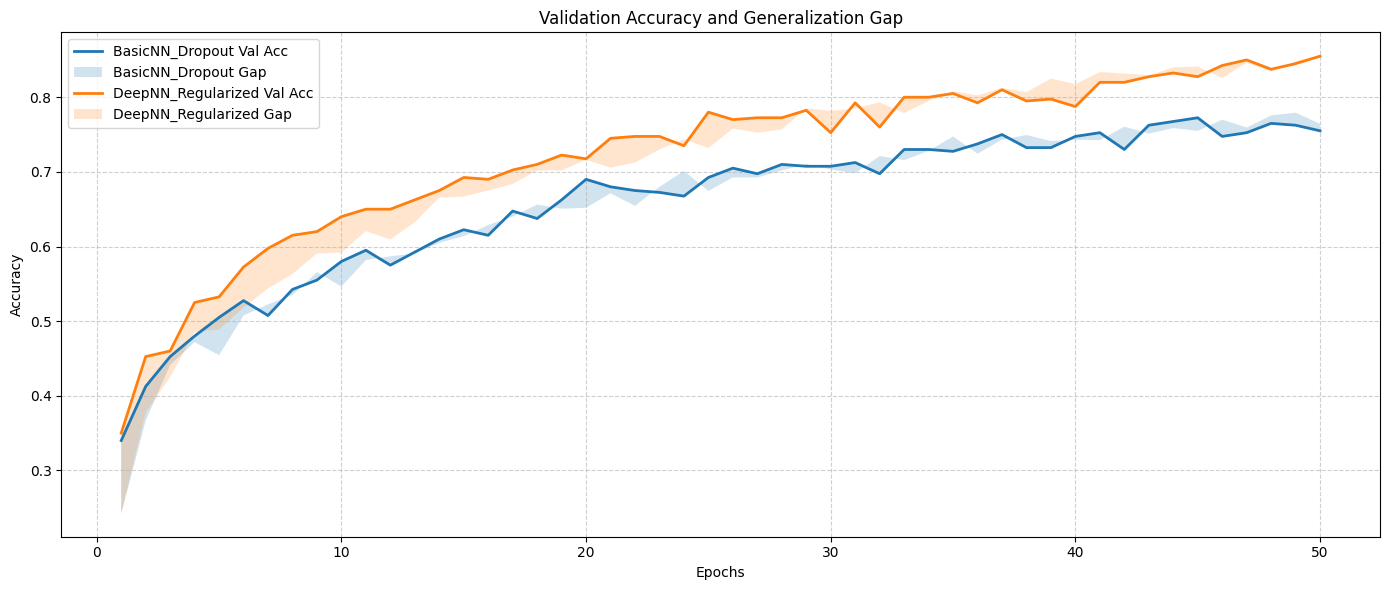

In [41]:
plt.figure(figsize=(14, 6))

for model_name, hist in nn_training_histories:
    epochs = range(1, len(hist.history['accuracy']) + 1)
    plt.plot(epochs, hist.history['val_accuracy'], label=f'{model_name} Val Acc', linewidth=2)
    plt.fill_between(epochs, hist.history['accuracy'], hist.history['val_accuracy'], alpha=0.2, label=f'{model_name} Gap')

plt.title('Validation Accuracy and Generalization Gap')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Combined Line Plot per Model

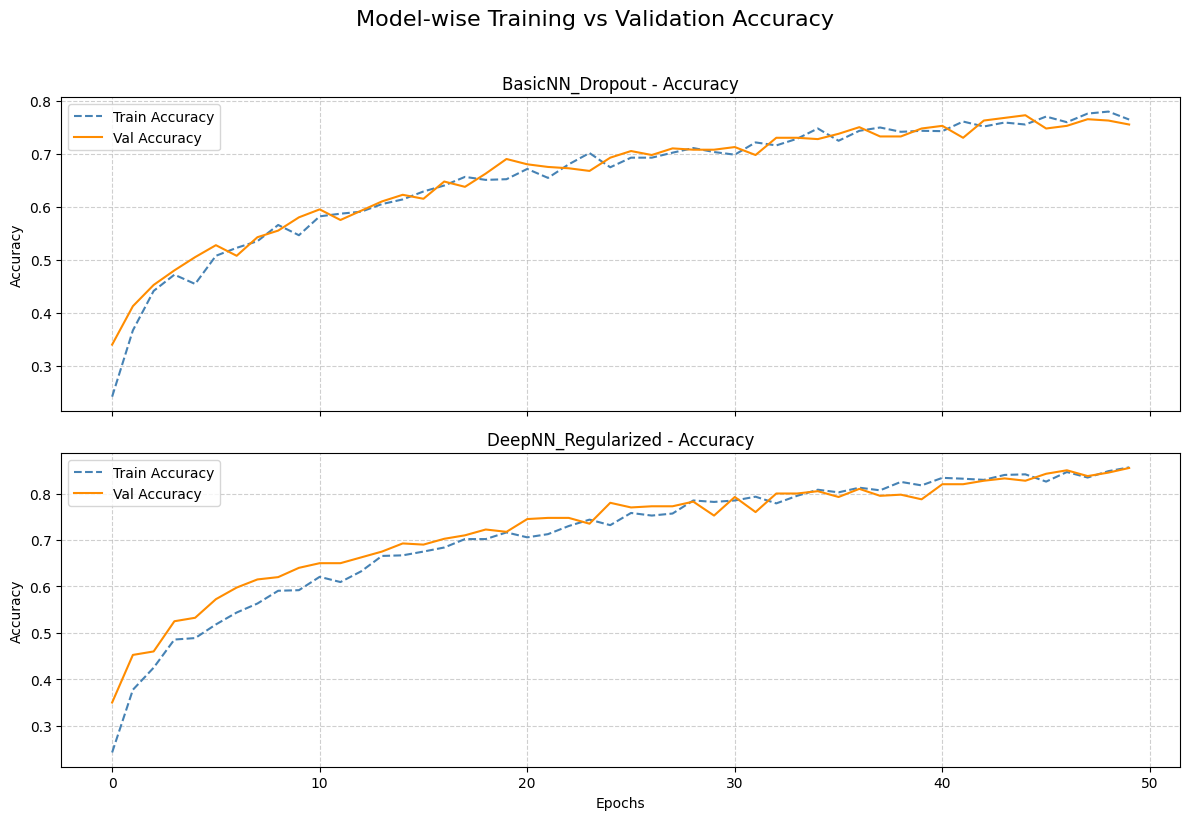

In [42]:
num_models = len(nn_training_histories)
fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=True)

for i, (model_name, hist) in enumerate(nn_training_histories):
    ax = axes[i]
    ax.plot(hist.history['accuracy'], label='Train Accuracy', linestyle='--', color='steelblue')
    ax.plot(hist.history['val_accuracy'], label='Val Accuracy', linestyle='-', color='darkorange')
    ax.set_title(f'{model_name} - Accuracy')
    ax.set_ylabel('Accuracy')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[-1].set_xlabel('Epochs')
plt.suptitle('Model-wise Training vs Validation Accuracy', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Evaluation and Results

Best ML Model: **CatBoost **(Robust Scaled)

Test Accuracy: 90.25%

Test F1 Score: 0.902

Best DL Model: **Deeper Neural Network with Regularized Dropout**

Validation Accuracy: 85.5%

Validation Loss: 0.4530


| Model Type    | Model Name                       | Accuracy   | F1 Score  |
| ------------- | -------------------------------- | ---------- | --------- |
| Classical ML  | **CatBoost (Robust Scaled)**     | **90.25%** | **0.902** |
| Deep Learning | Deeper Neural Net (Reg. Dropout) | 85.50%     | \~0.85    |


**Recommended Final Model: CatBoost (Classical ML)**

CatBoost outperformed all other models, including deep learning, in both accuracy and F1 score.

It also requires significantly less training time and computational resources than deep neural networks.

Additionally, it handles categorical data, noise, and overfitting effectively with minimal hyperparameter tuning.



# Deployment

Hypothetical Deployment Scenario:

Emotion detection integrated into a real-time voice assistant or chatbot

Backend service using FastAPI or Flask serving the model

Frontend: Live audio input with feedback on predicted emotion

# Discussion and Conclusions

The project successfully demonstrated the ability of machines to learn emotional patterns in human speech using both classical and deep learning models. Among all the models evaluated:

The CatBoost classifier emerged as the most effective, achieving 90.25% accuracy and 0.902 F1 score, confirming its capability to handle complex audio feature representations.

The Deeper Neural Network with regularized dropout also performed competitively with 85.5% accuracy, validating the potential of deep learning for more nuanced emotional modeling with further tuning.

Key Takeaways:

Acoustic features (MFCCs, energy, pitch, ZCR) can robustly represent emotional patterns in speech.

Ensemble tree-based models, especially CatBoost and XGBoost, are highly effective for emotion classification from structured audio features.

Deep learning models show promising results and generalize well with regularization and sufficient data but require more training time and fine-tuning.

The use of RobustScaler preprocessing contributed to more stable and higher-performing models across the board.

Future Work:

Deploy the CatBoost model with a simple Flask API for real-time emotion detection.

Incorporate more diverse datasets (e.g., CREMA-D, TESS) for generalizability.

Explore audio-based Transformers or CNN-RNN hybrid models for end-to-end learning from raw waveforms.

# Save the file as PDF

In [44]:
!apt-get update
!apt-get install pandoc
!apt-get install inkscape
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-extra

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,532 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,340 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe

In [58]:
%shell jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Shruthi_AK_AAI_510_IN1_Final_Project_Group_3.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Shruthi_AK_AAI_510_IN1_Final_Project_Group_3.ipynb to pdf
[NbConvertApp] Support files will be in Shruthi_AK_AAI_510_IN1_Final_Project_Group_3_files/
[NbConvertApp] Making directory ./Shruthi_AK_AAI_510_IN1_Final_Project_Group_3_files
[NbConvertApp] Writing 482832 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 4256397 bytes to /content/drive/MyDrive/Colab Notebooks/Shruthi_AK_AAI_510_IN1_Final_Project_Group_3.pdf
